# FarmVibes.AI Sentinel/SpaceEye Demo
This notebook demonstrates how FarmVibes.AI can be used to download and preprocess Sentinel data, as well as how to obtain cloud-free images using SpaceEye. We use workflows to investigate deforestation in the Amazon Rainforest in Brazil.

### Conda environment setup
To install the required packages, see [this README file](../README.md).

------------------------


In [1]:
from copy import deepcopy
from datetime import date, datetime
import io
import math

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from tqdm.auto import tqdm

from IPython.display import display, Image
from rasterio.mask import mask, geometry_window
from shapely import geometry as shpg
from vibe_core.client import get_default_vibe_client

In [2]:
# Helper functions

def lw_plot():
    """
    Compress images to make notebook smaller
    """
    iobytes = io.BytesIO()
    plt.savefig(iobytes, format='jpg', bbox_inches="tight")
    plt.close()
    iobytes.seek(0)
    display(Image(data=iobytes.read()))

    
def transparent_cmap(cmap, max_alpha=0.8, N=255):
    "Copy colormap and set alpha values"
    mycmap = deepcopy(cmap)
    mycmap._init()
    mycmap._lut[:, -1] = np.linspace(0, max_alpha, N + 4)
    return mycmap


def s1_to_img(ar):
    """
    Compute Sentinel-1 RGB-composite image for display
    """
    nodata = ar.sum(axis=0) == 0
    ar = np.stack((ar[1], ar[0], ar[1] - ar[0]), axis=-1)
    qmin, qmax = np.quantile(ar[~nodata], (.01, .99), axis=0)
    ar = np.clip((ar - qmin[None, None]) / (qmax - qmin)[None, None], 0, 1)
    ar[nodata] = 0
    return ar


def s2_to_img(ar, rgb_idx=[3, 2, 1]):
    """
    Normalize Sentinel-2 RGB channels for display
    """
    return (ar[rgb_idx] / 3000).clip(0, 1).transpose((1, 2, 0))

                                                     
def read_raster(raster, geometry=None, window=None, **kwargs):
    """
    Read data from a Raster. If a geometry or window is passed, only that portion of the raster is read.
    """
    with rasterio.open(raster.raster_asset.url, **kwargs) as src:
        if geometry is not None:
            return mask(src, [geometry], crop=True, **kwargs)[0]
        return src.read(window=window)

# Sentinel-2

## Workflow input
The workflows take as input a region, defined via a geometry in EPSG:4326 (`shapely` object), and a time range (tuple of `datetime`). For this example we select a region inside the Amazon Rainforest, in order to verify deforestation over five years. The region of interest is shown below, along with the Amazon biome borders, downloaded from [TerraBrasilis](http://terrabrasilis.dpi.inpe.br/en/home-page/), which is a platform built by INPE (National Institute for Space Research) for environmental monitoring.

In [3]:
# Input geometry: shapely object
geom = shpg.Point(-55.252304077148445, -6.424483546180726).buffer(.05, cap_style=3)
# Time range: tuple of datetime. 3 month period in 2018
time_range = (datetime(2018, 6, 1), datetime(2018, 9, 1))

In [4]:
# Download biome borders to /tmp/amazon_shape
!mkdir /tmp/amazon_shape
!wget http://terrabrasilis.dpi.inpe.br/download/dataset/amz-aux/vector/amazon_biome_border.zip -O /tmp/amazon_shape/amazon_biome_border.zip

mkdir: cannot create directory ‘/tmp/amazon_shape’: File exists
--2022-11-09 17:57:40--  http://terrabrasilis.dpi.inpe.br/download/dataset/amz-aux/vector/amazon_biome_border.zip
Resolving terrabrasilis.dpi.inpe.br (terrabrasilis.dpi.inpe.br)... 150.163.2.5
Connecting to terrabrasilis.dpi.inpe.br (terrabrasilis.dpi.inpe.br)|150.163.2.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4267832 (4.1M) [application/zip]
Saving to: ‘/tmp/amazon_shape/amazon_biome_border.zip’

/tmp/amazon_shape/a 100%[===================>]   4.07M   335KB/s    in 15s     

2022-11-09 17:57:55 (282 KB/s) - ‘/tmp/amazon_shape/amazon_biome_border.zip’ saved [4267832/4267832]



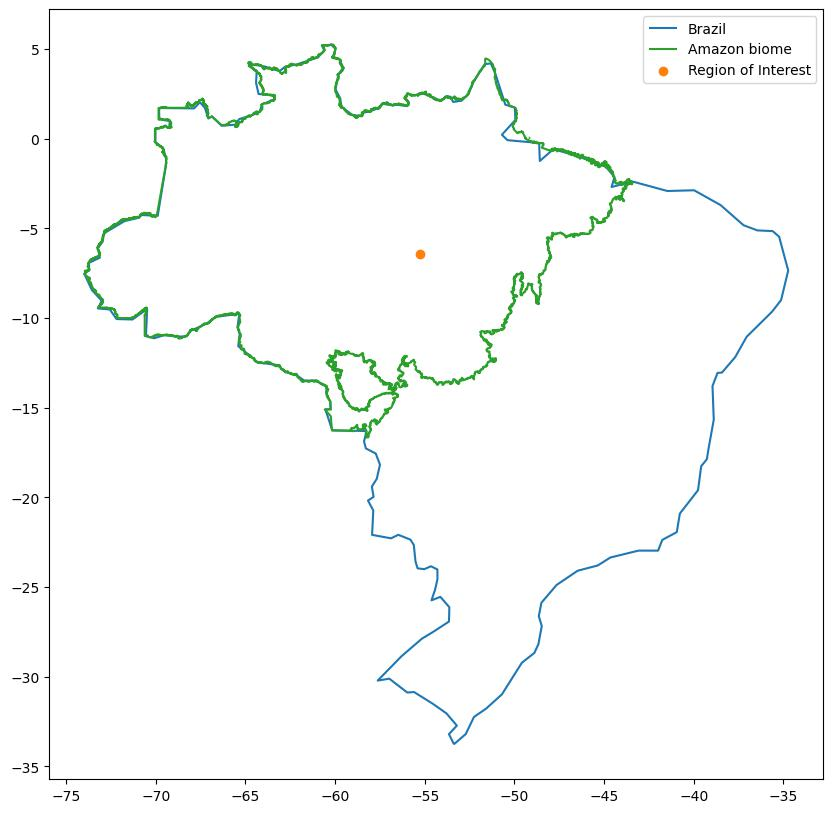

In [5]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query("name == 'Brazil'").boundary.plot(ax=ax)
gpd.read_file("/tmp/amazon_shape/amazon_biome_border.zip").boundary.plot(ax=ax, color="C2")
gpd.GeoSeries(geom.centroid).plot(ax=ax, color="C1")
plt.legend(["Brazil", "Amazon biome", "Region of Interest"])
lw_plot()

## Downloading Sentinel-2 data
Sentinel-2 related workflows have the prefix `data_ingestion/sentinel2`. To download a minimum set of products that cover the input region during the input time range, the `data_ingestion/sentinel2/preprocess_s2` workflow can be used. As with all other workflows, details about these workflows are available via the `document_workflow` method.

In [6]:
# Get client pointing to our local cluster
client = get_default_vibe_client()

In [7]:
# Details about the workflow, such as inputs, output, and parameters
client.document_workflow("data_ingestion/sentinel2/preprocess_s2")

Workflow: data_ingestion/sentinel2/preprocess_s2

Description:

Downloads and preprocesses Sentinel-2 imagery that covers the input geometry and time range.    
    This workflow selects a minimum set of tiles that covers the input geometry, downloads          
    Sentinel-2 imagery for the selected time range, and preprocesses it by generating a single      
    multi-band raster at 10m resolution.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 L2A rasters with all bands       
    resampled to 10m resolution.

- mask (vibe_core.data.sentinel.Sentinel2CloudMask): Cloud mask at 10m resolution from the      
    product's quality indicators.

Parameters:

- min_tile_cover (default: task defined): Minimum RoI coverage to consider a set of tiles       
    sufficient.

- max_tiles_per_time (default: task defined): Maximum number of tiles used to cover the RoI in  
    each date.

- pc_key (default: task defined): Planetary computer API key.

Tasks:

- list

- filter

- download

- preprocess

- group

- merge

In [8]:
run = client.run(
        "data_ingestion/sentinel2/preprocess_s2",
        f"Amazon {time_range[0].year}",
        geometry=geom,
        time_range=time_range,
        parameters={"pc_key": "@SECRET(eywa-secrets, pc-sub-key)"}
)

In [9]:
run.monitor()

Output()

## Workflow outputs
After the workflow is done, the outputs can be accessed via the `output` property. It is a dictionary, with keys being the `sink` names, as shown in the workflow documentation. For these workflows, the output rasters are available via the `raster` key. 

### Reading raster data
Each raster contains an asset, which has a reference to a `tiff` file. The referenced file contains data for the whole tile (approx. 11k x 11k pixels at 10m resolution). The tiffs are tiled, so a portion of the image can be easily accessed without loading the whole file in memory. We use the `rasterio` library to read these rasters.

The image below showcases a downloaded tile, as well as the input region of interest, shown in red.

### Geometry projection
All geometries used in FarmVibes.AI are in EPSG:4326, which is a geographic coordinate system. Sentinel-2 rasters are provided in local projected CRSs (UTM). Before using our input geometry to read from the raster, we must project it to the raster CRS. This can be done without reading any raster data.

In [10]:
# Project the input geometry (in EPSG:4326) to the raster CRS
with rasterio.open(run.output["raster"][0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope

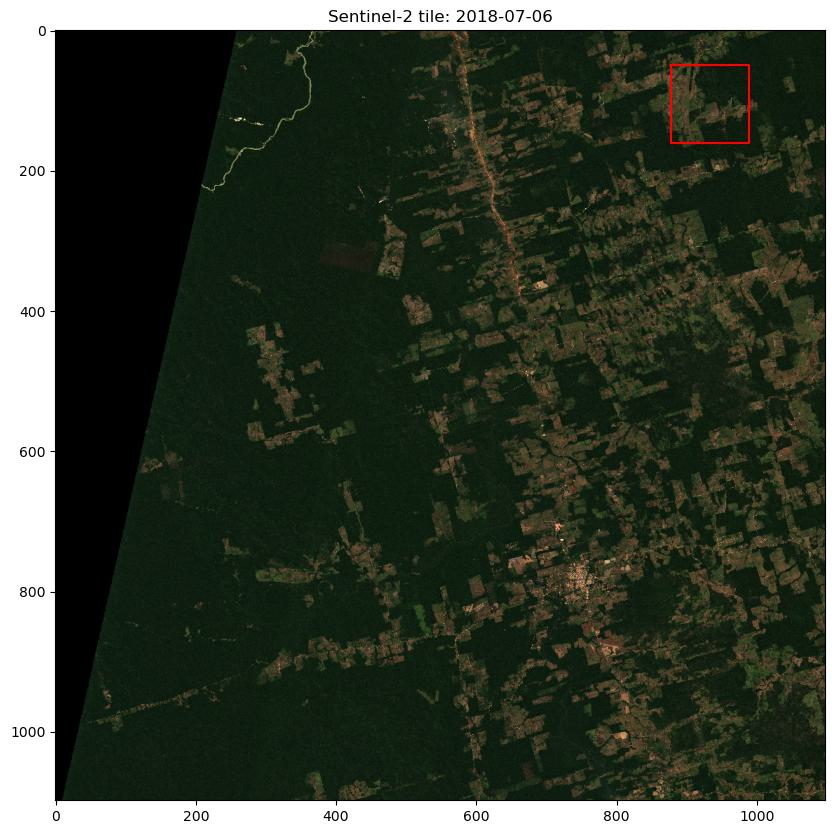

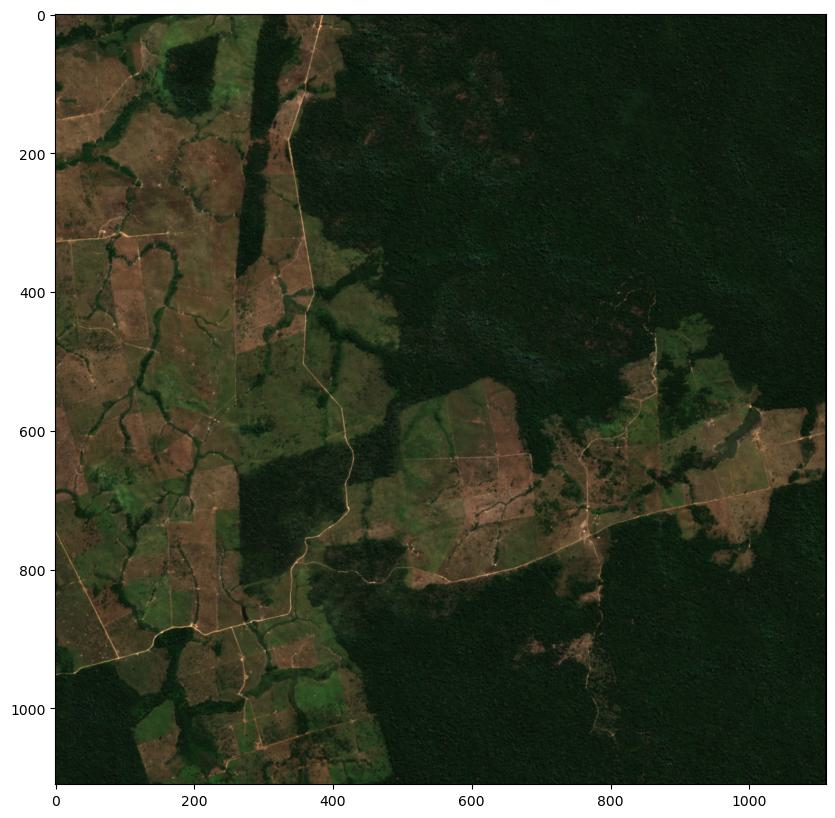

In [11]:
# Outputs are the entire tiles, here is our input region in the tile
s2 = run.output["raster"][11]

# A reference to the file can be obtained via `raster_asset.url`
with rasterio.open(s2.raster_asset.url) as src:
    # Get window (in pixels) from the geometry in the tiff (projected) CRS
    win = geometry_window(src, [proj_geom])
    boxx, boxy = win.toranges()[::-1]
    boxx = boxx + boxx[::-1] + boxx[:1]
    boxy = tuple(b for b in boxy for _ in range(2)) + boxy[:1]
    # Read the whole tile
    ar = src.read()
    plt.figure(figsize=(10, 10))
    plt.title(f"Sentinel-2 tile: {s2.time_range[0].strftime('%Y-%m-%d')}")
    # Subsample the image by 10 for plotting
    plt.imshow(s2_to_img(ar[:, ::10, ::10]))
    plt.plot([b/10 for b in boxx], [b/10 for b in boxy], 'r')
    lw_plot()

plt.figure(figsize=(10, 10))
plt.imshow(s2_to_img(read_raster(s2, geometry=proj_geom)))
lw_plot()

## Working with cloud masks
In order to compute better cloud masks, the `data_ingestion/sentinel2/preprocess_s2_improved_masks` workflow also runs machine learning models over the image pixels to improve the product masks. This results in more accurate masks, but takes longer to run. It is recommended to use improved masks when cloud masks are needed. 

In [12]:
client.document_workflow("data_ingestion/sentinel2/preprocess_s2_improved_masks")

Workflow: data_ingestion/sentinel2/preprocess_s2_improved_masks

Description:

Downloads and preprocesses Sentinel-2 imagery that covers the input geometry and time range, and
    computes improved cloud masks using cloud and shadow segmentation models. This workflow selects 
    a minimum set of tiles that covers the input geometry, downloads Sentinel-2 imagery for the     
    selected time range, and preprocesses it by generating a single multi-band raster at 10m        
    resolution. It then improves cloud masks by merging the product mask with cloud and shadow masks
    computed using cloud and shadow segmentation models.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 L2A rasters with all bands       
    resampled to 10m resolution.

- mask (vibe_core.data.sentinel.Sentinel2CloudMask): Cloud masks at 10m resolution.

Parameters:

- min_tile_cover (default: task defined): Minimum RoI coverage to consider a set of tiles       
    sufficient.

- max_tiles_per_time (default: task defined): Maximum number of tiles used to cover the RoI in  
    each date.

- cloud_thr (default: task defined): Confidence threshold to assign a pixel as cloud.

- shadow_thr (default: task defined): Confidence threshold to assign a pixel as shadow.

- pc_key (default: task defined): Planetary computer API key.

Tasks:

- s2: Downloads and preprocesses Sentinel-2 imagery that covers the input geometry and time     
    range.

- cloud: Improves cloud masks by merging the product cloud mask with cloud and shadow masks     
    computed by machine learning segmentation models.

In [13]:
run2 = client.run(
        "data_ingestion/sentinel2/preprocess_s2_improved_masks",
        f"Amazon {time_range[0].year}",
        geometry=geom,
        time_range=time_range,
        parameters={"pc_key": "@SECRET(eywa-secrets, pc-sub-key)"}
)
run2.monitor()

Output()

## Visualizing cloud masks
Let's visualize the cloud masks overlaid on the Sentinel-2 image to showcase the difference in masks quality.

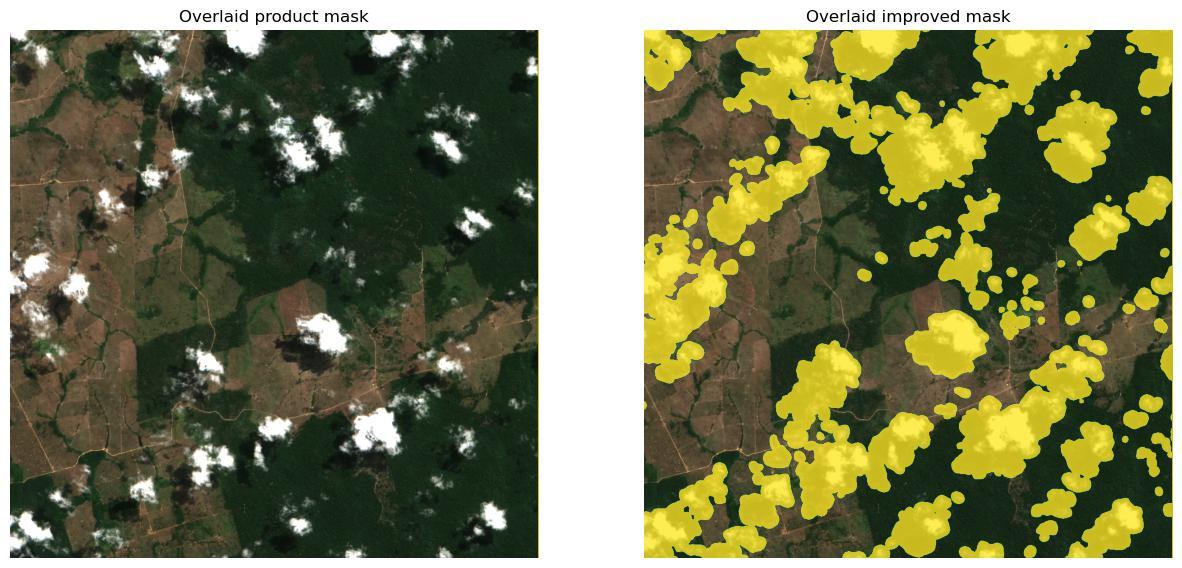

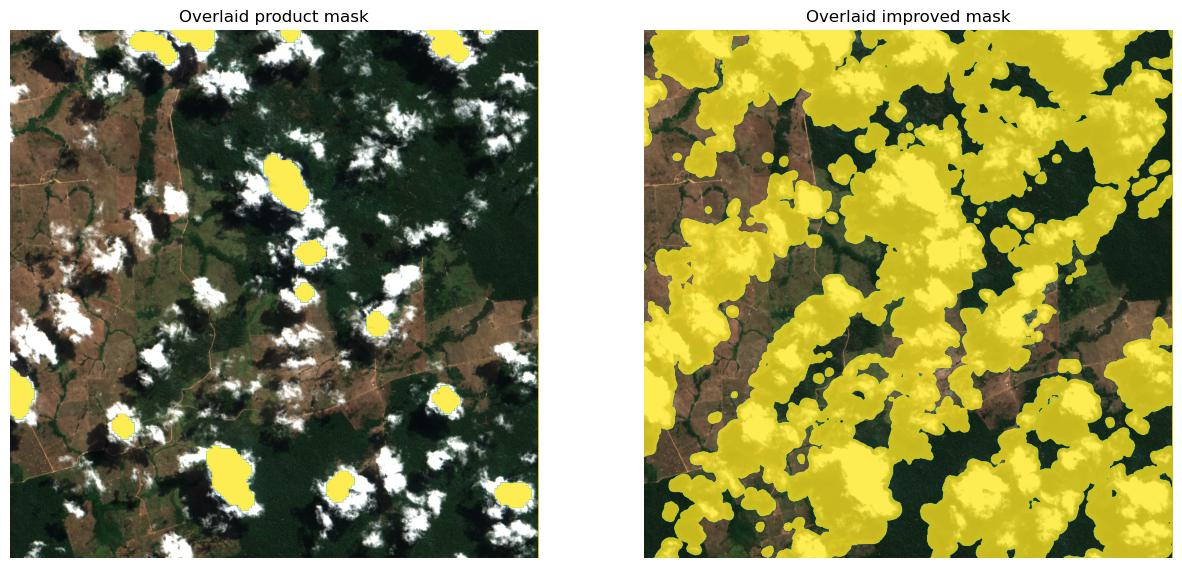

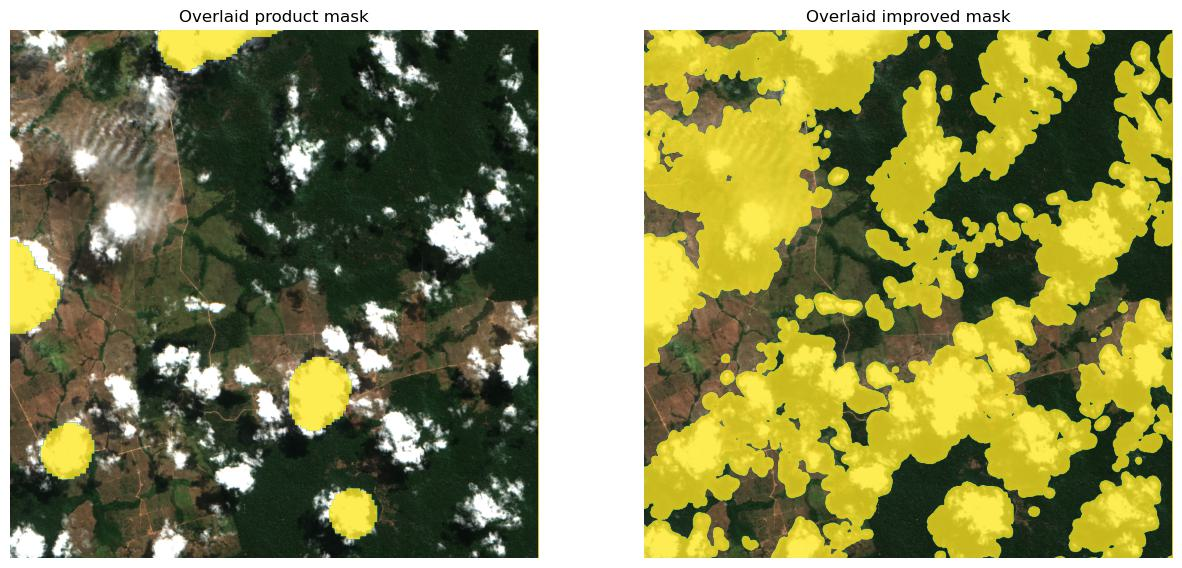

In [14]:
idxs = [2, 5, 6]
for idx in idxs:
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(s2_to_img(read_raster(run.output["raster"][idx], proj_geom)))
    plt.imshow(read_raster(run.output["mask"][idx], proj_geom)[0], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title("Overlaid product mask")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(s2_to_img(read_raster(run.output["raster"][idx], proj_geom)))
    plt.imshow(read_raster(run2.output["mask"][idx], proj_geom)[0], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title("Overlaid improved mask")
    plt.axis("off")
    lw_plot()

## Cloud cover
Cloud masks can be used to select cloud-free images automatically, or mask out cloudy regions during aggregation.

In [15]:
# Selecting rasters with less than 10% of cloudy pixels
cloud_thr = .1
cloud_ratio = [read_raster(c, geometry=proj_geom, filled=False).mean() for c in tqdm(run2.output["mask"])]
cloud_free_rasters = [s2 for s2, c in zip(run.output["raster"], cloud_ratio) if c < cloud_thr]
cloudy_rasters = [s2 for s2, c in zip(run.output["raster"], cloud_ratio) if c >= cloud_thr]

  0%|          | 0/19 [00:00<?, ?it/s]

In [16]:
print("Cloud cover")
for x, y in zip(run2.output["mask"], cloud_ratio):
    print(f"{x.time_range[0].strftime('%Y-%m-%d')}: {y:.2%}")

Cloud cover
2018-08-30: 1.69%
2018-08-25: 0.00%
2018-08-20: 39.68%
2018-08-15: 100.00%
2018-08-10: 100.00%
2018-08-05: 64.76%
2018-07-31: 60.33%
2018-07-26: 0.00%
2018-07-21: 0.01%
2018-07-16: 1.18%
2018-07-11: 0.03%
2018-07-06: 0.00%
2018-07-01: 0.00%
2018-06-26: 0.00%
2018-06-21: 7.23%
2018-06-16: 0.00%
2018-06-11: 65.13%
2018-06-06: 100.00%
2018-06-01: 13.60%


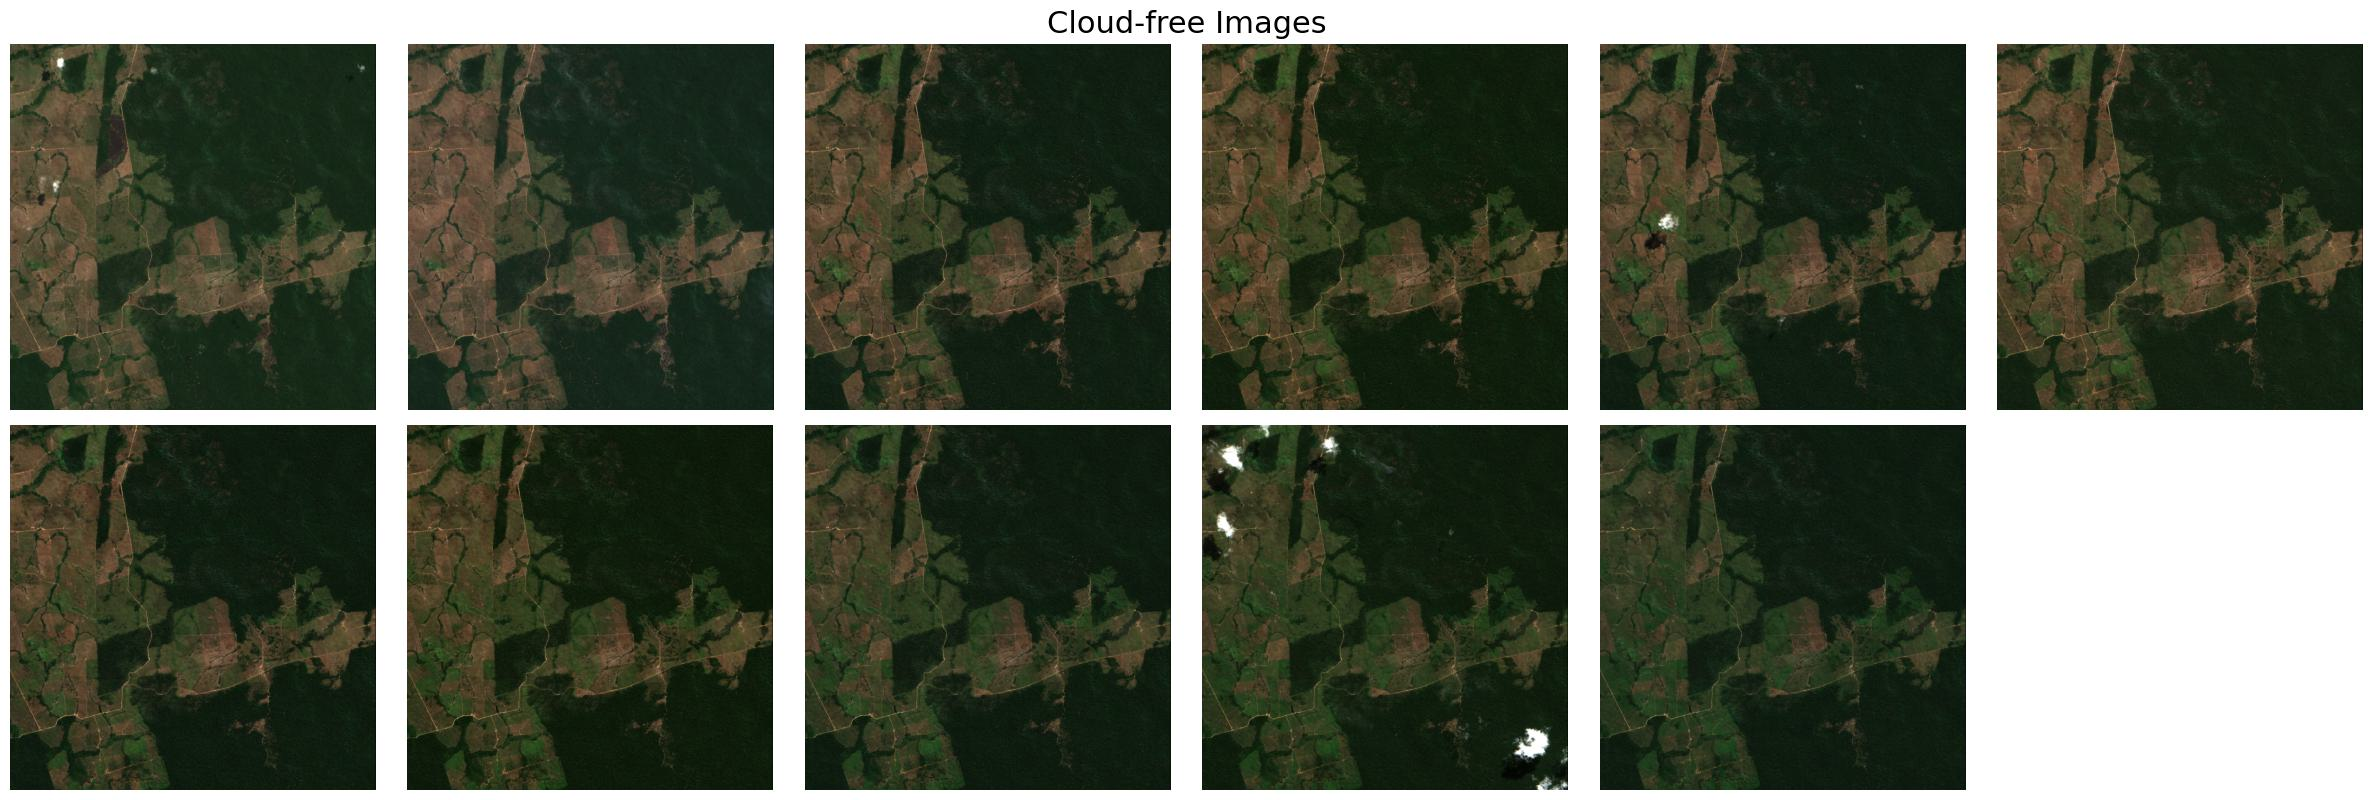

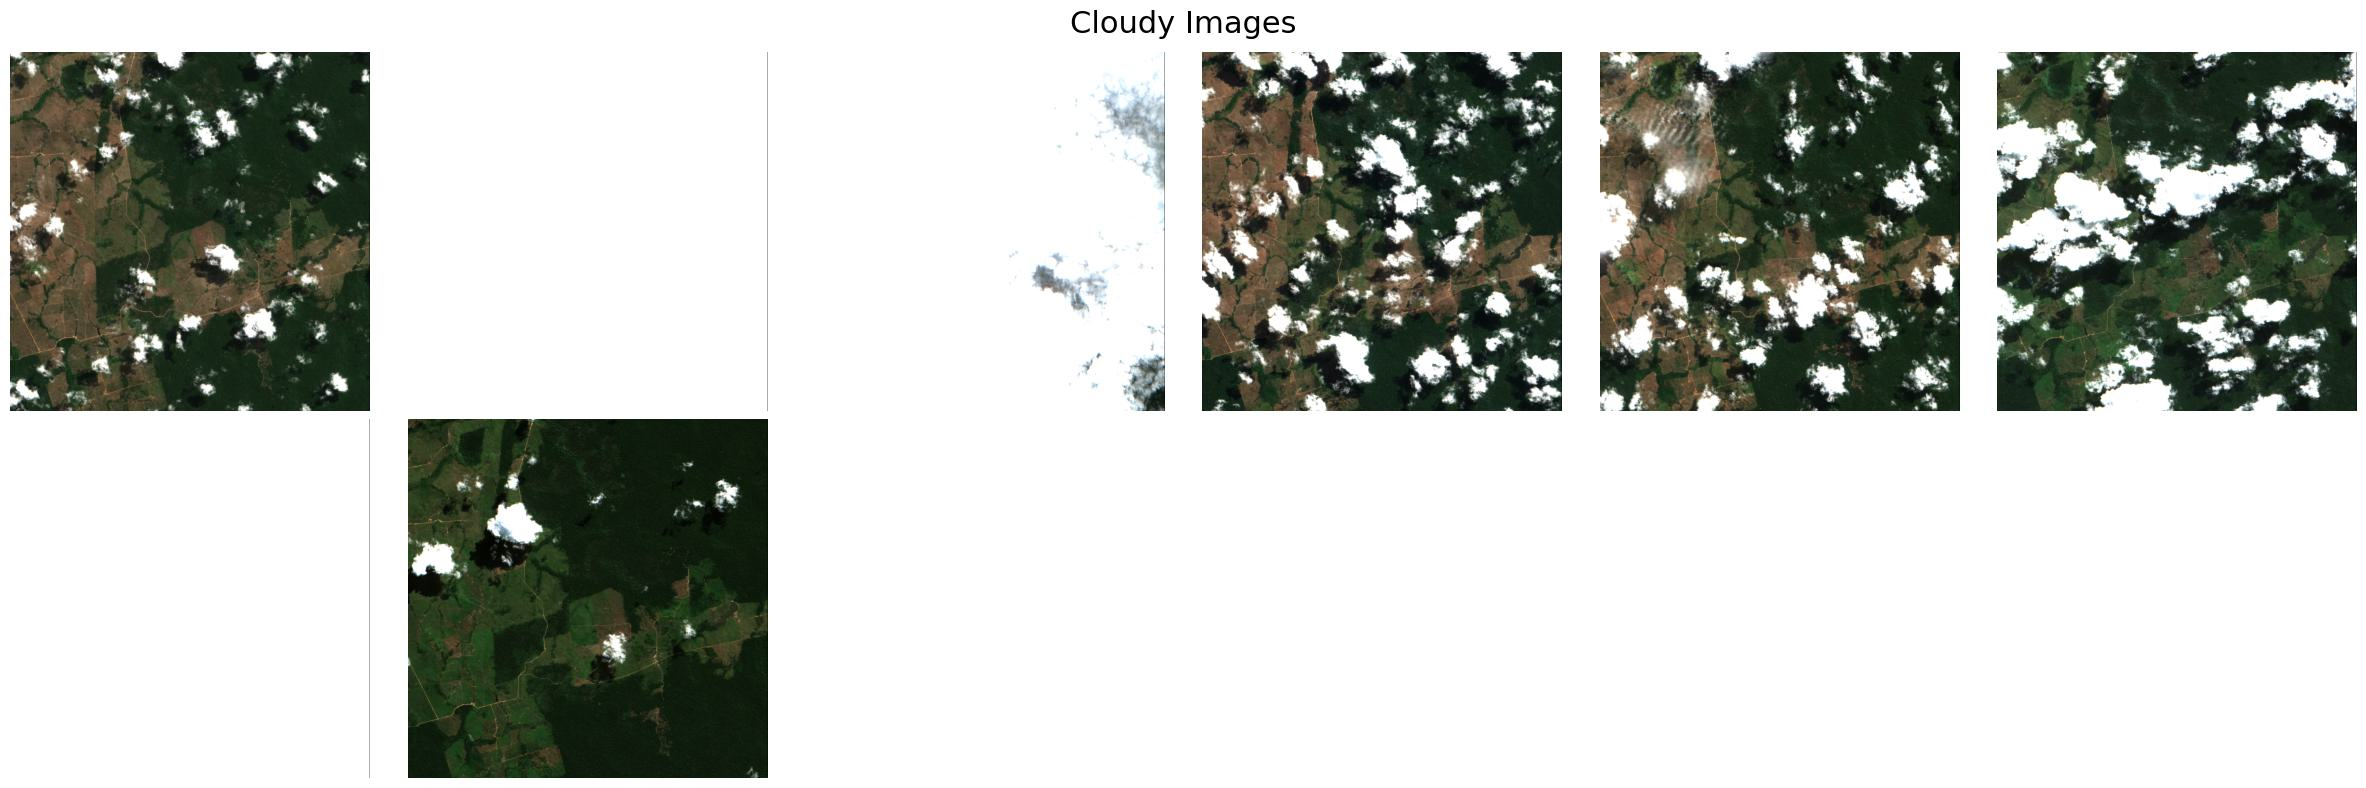

In [17]:
# Let's check the cloud-free rasters
N = 6
S = 4
H = math.ceil(len(cloud_free_rasters) / S)
plt.figure(figsize=(N*S, H*S))
for i, r in enumerate(cloud_free_rasters):
    plt.subplot(H, N, i + 1)
    plt.imshow(s2_to_img(read_raster(r, geometry=proj_geom)))
    plt.axis("off")
plt.suptitle("Cloud-free Images", fontsize=22)
plt.tight_layout()
lw_plot()
# And cloudy ones
H = math.ceil(len(cloudy_rasters) / S)
plt.figure(figsize=(N*S, H*S))
for i, r in enumerate(cloudy_rasters):
    plt.subplot(H, N, i + 1)
    plt.imshow(s2_to_img(read_raster(r, geometry=proj_geom)))
    plt.axis("off")
plt.suptitle("Cloudy Images", fontsize=22)
plt.tight_layout()
lw_plot()

## VIsualizing deforestation over the years
We'll now run the same workflow over 5 years to check the effects of deforestation on the area. For each year, we can select a cloud-free image and compare the changes at an approximate one-year interval. We'll submit 5 different workflow runs, one for each year time range. Since we have already run the worklfow for 2018, no computation will be performed (all the outputs will be fetched from the cache).

In [18]:
# Time ranges: 3 month periods for each year, from 2018 to 2022
time_ranges = [(datetime(year, 6, 1), datetime(year, 9, 1)) for year in range(2018, 2023)]

In [19]:
# Request one workflow run per time range
runs = [
    client.run(
        "data_ingestion/sentinel2/preprocess_s2_improved_masks",
        f"Amazon {tr[0].year}",
        geometry=geom,
        time_range=tr,
        parameters={"pc_key": "@SECRET(eywa-secrets, pc-sub-key)"}
    ) for tr in time_ranges
]
[r.monitor() for r in runs]

Output()

Output()

Output()

Output()

Output()

[None, None, None, None, None]

### Available imagery over the 3-month period
Let's first check the available imagery for each time period.

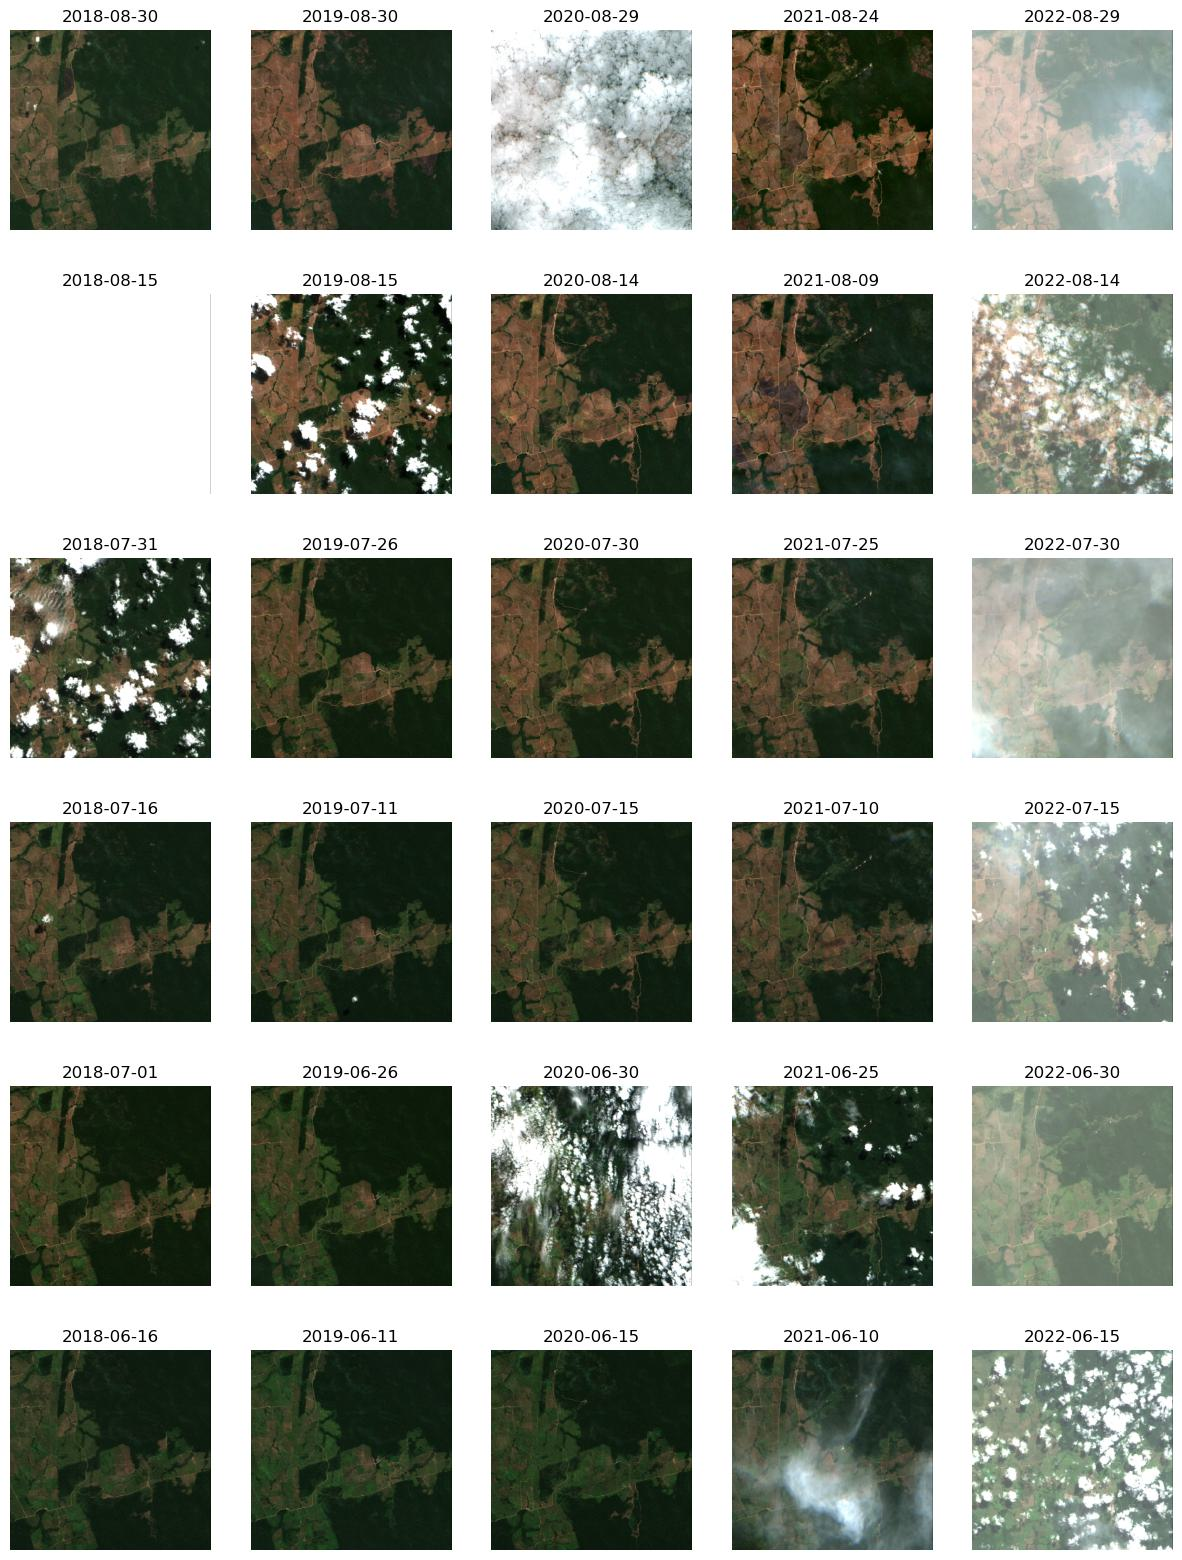

In [20]:
plt.figure(figsize=(15, 20))
plot_idx = 1
for i in range(0, min([len(r.output["raster"]) for r in runs]), 3):
    for j, r in enumerate(runs):
        s2 = r.output["raster"][i]
        ar = read_raster(s2, geometry=proj_geom)
        plt.subplot(6, 5, plot_idx)
        plt.title(s2.time_range[0].strftime("%Y-%m-%d"))
        plt.imshow(s2_to_img(ar))
        plt.axis("off")
        plot_idx += 1
lw_plot()

### Deforestation effects
On the images below, we highlight visible signs of deforestation in the highlighted area. While no change is seen from 2018 to 2019, every year after shows increased deforestation. Note the road going deeper into the forest at each year.

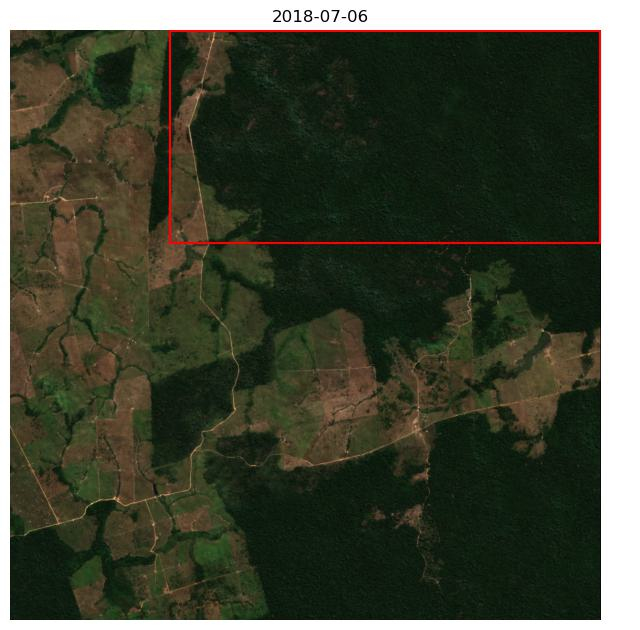

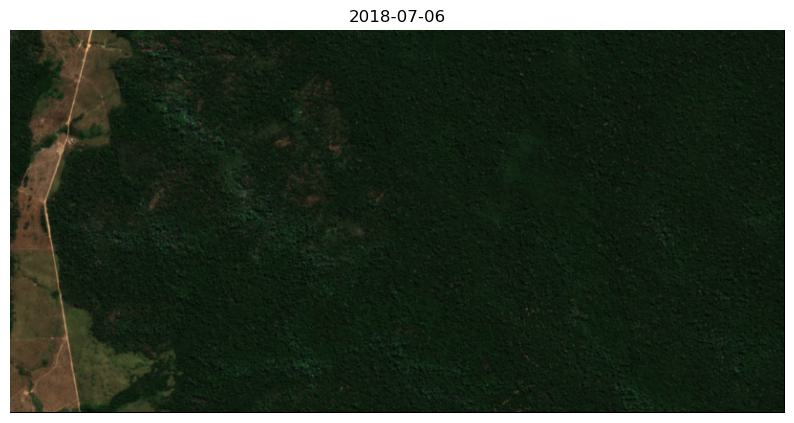

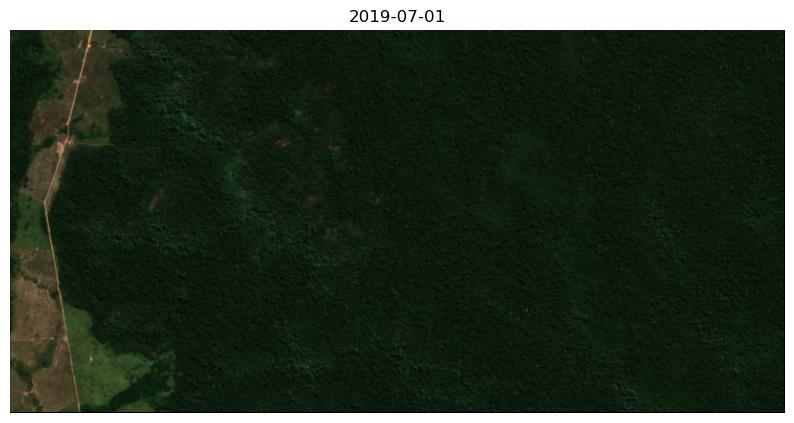

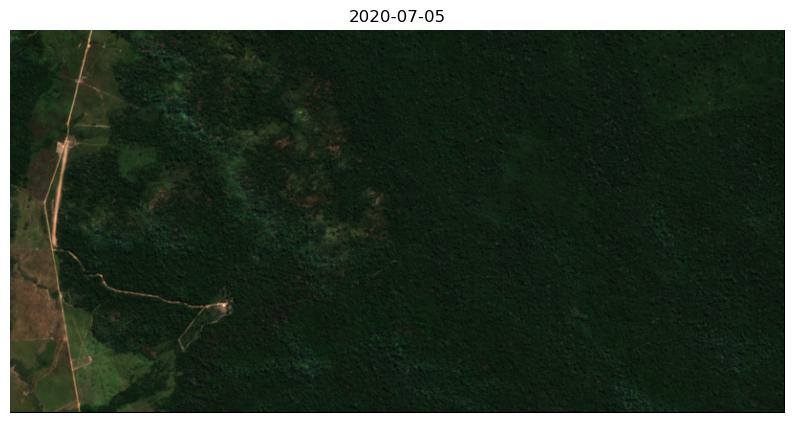

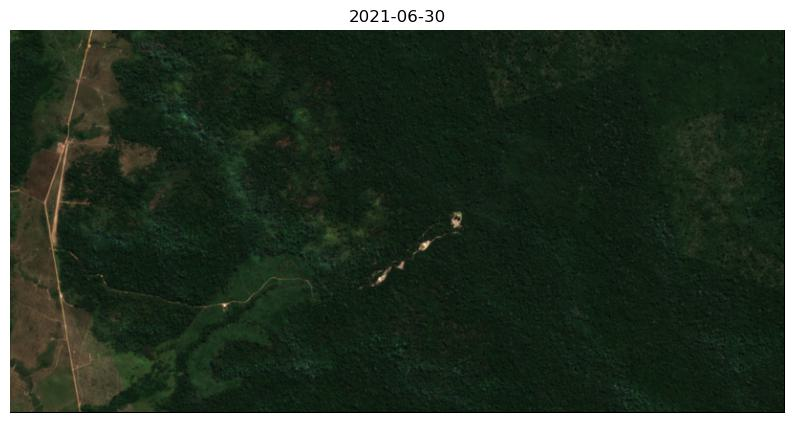

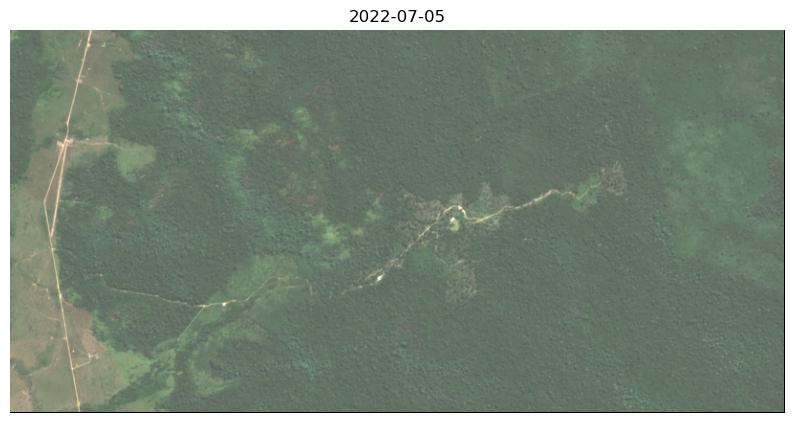

In [21]:
xmin, ymin, xmax, ymax = proj_geom.bounds
focus_geom = shpg.box(xmin + 3000, ymax - 4000, xmax, ymax)

plt.figure(figsize=(8, 8))
s2 = runs[0].output["raster"][11]
ar = s2_to_img(read_raster(s2, geometry=proj_geom))
plt.imshow(ar)
plt.plot([300, ar.shape[1], ar.shape[1], 300, 300], [0, 0, 400, 400, 0], color="red")
plt.axis("off")
plt.title(f"{s2.time_range[0].strftime('%Y-%m-%d')}")
lw_plot()
for run in runs:
    s2 = run.output["raster"][11]
    plt.figure(figsize=(10, 5))
    plt.imshow(s2_to_img(read_raster(s2, geometry=focus_geom)))
    plt.axis("off")
    plt.title(f"{s2.time_range[0].strftime('%Y-%m-%d')}")
    lw_plot()

# Sentinel-1
The Sentinel-1 mission is comprised of satellites that carry a synthetic-aperture radar (SAR) instrument. This allows it to collect data in any weather condition, as the radar signal penetrates clouds. Below we show case how one might use FarmVibes.AI to download and preprocess Sentinel-1 data into Sentinel-2 aligned tiles. These aligned images can be used by the SpaceEye model to inpaint cloudy regions.

## Download and preprocessing
Sentinel-1 data is provided in a different tiling system than Sentinel-2. FarmVibes.AI preprocessing workflows will download the necessary data and preprocess it in order to generate Sentinel-1 data in the Sentinel-2 grid.

### Sentinel-1 product selection
The workflow will automatically select the necessary products in order to cover the Sentinel-2 tile. It will then preprocess and merge that information, in order to generate a Sentinel-1 image in the necessary Sentinel-2 tiles. Below is an example of the S1 tiles that intersect with out S2 tile of interest.

In [22]:
import yaml
with open("list_s1.yaml") as f:
    wf_dict = yaml.safe_load(f)

s1_list_run = client.run(wf_dict, "S1 Products", geometry=geom, time_range=time_range).block_until_complete()

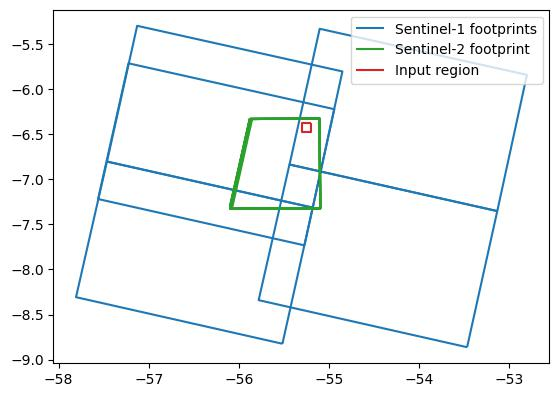

In [23]:
ax = plt.gca()
gpd.GeoSeries([shpg.shape(x.geometry) for x in s1_list_run.output["s1_products"][:5]]).boundary.plot(ax=ax)
gpd.GeoSeries([shpg.shape(x.geometry) for x in run.output["raster"]]).boundary.plot(ax=ax, color="C2")
gpd.GeoSeries(geom).boundary.plot(ax=ax, color="C3")
plt.legend(["Sentinel-1 footprints", "Sentinel-2 footprint", "Input region"])
lw_plot()

## Preprocessing workflow
The `data_ingestion/spaceeye/spaceeye_preprocess` workflow will download and preprocess all Sentinel-1 and Sentinel-2 data available for the input time range. It will also generate the improved cloud masks described previously. The Sentinel-1 data will be available in the same tiles as Sentinel-2.

In [24]:
client.document_workflow("data_ingestion/spaceeye/spaceeye_preprocess")

Workflow: data_ingestion/spaceeye/spaceeye_preprocess

Description:

Runs the SpaceEye preprocessing pipeline. The workflow fetches both Sentinel-1 and Sentinel-2   
    tiles that cover the input geometry and time range and preprocesses them. It also computes      
    improved cloud masks using cloud and shadow segmentation models. This workflow requires a Scihub
    account.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- s2_raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 rasters.

- s1_raster (vibe_core.data.sentinel.Sentinel1Raster): Sentinel-1 rasters.

- cloud_mask (vibe_core.data.sentinel.Sentinel2CloudMask): Cloud and cloud shadow mask.

Parameters:

- pc_key (default: task defined): Planetary computer API key.

- scihub_user (default: task defined): Scihub user. Required to run the workflow.

- scihub_password (default: task defined): Scihub password. Required to run the workflow.

Tasks:

- s2: Downloads and preprocesses Sentinel-2 imagery that covers the input geometry and time     
    range, and computes improved cloud masks using cloud and shadow segmentation models.

- s1: Downloads and preprocesses tiles of Sentinel-1 imagery that intersect with the input      
    Sentinel-2 products in the input time range.

In [25]:
s1_run = client.run("data_ingestion/spaceeye/spaceeye_preprocess", "SpaceEye Preprocess Amazon 2018", geometry=geom, time_range=time_range)
s1_run.monitor()

Output()

In [26]:
# Tile information is also present in the Sentinel-1 rasters
print(s1_run.output["s1_raster"][0].tile_id)
print(s1_run.output["s2_raster"][0].tile_id)

21MXN
21MXN


In [27]:
s1_run.output.keys()

dict_keys(['s2_raster', 's1_raster', 'cloud_mask'])

Below are the available imagery from both Sentinel-1 and Sentinel-2. Note that they are available at different dates, due to them being captured by different platforms. Also see that while cloud coverage is clearly visible in Sentinel-2, weather effects do not interfere with Sentinel-1 imagery.

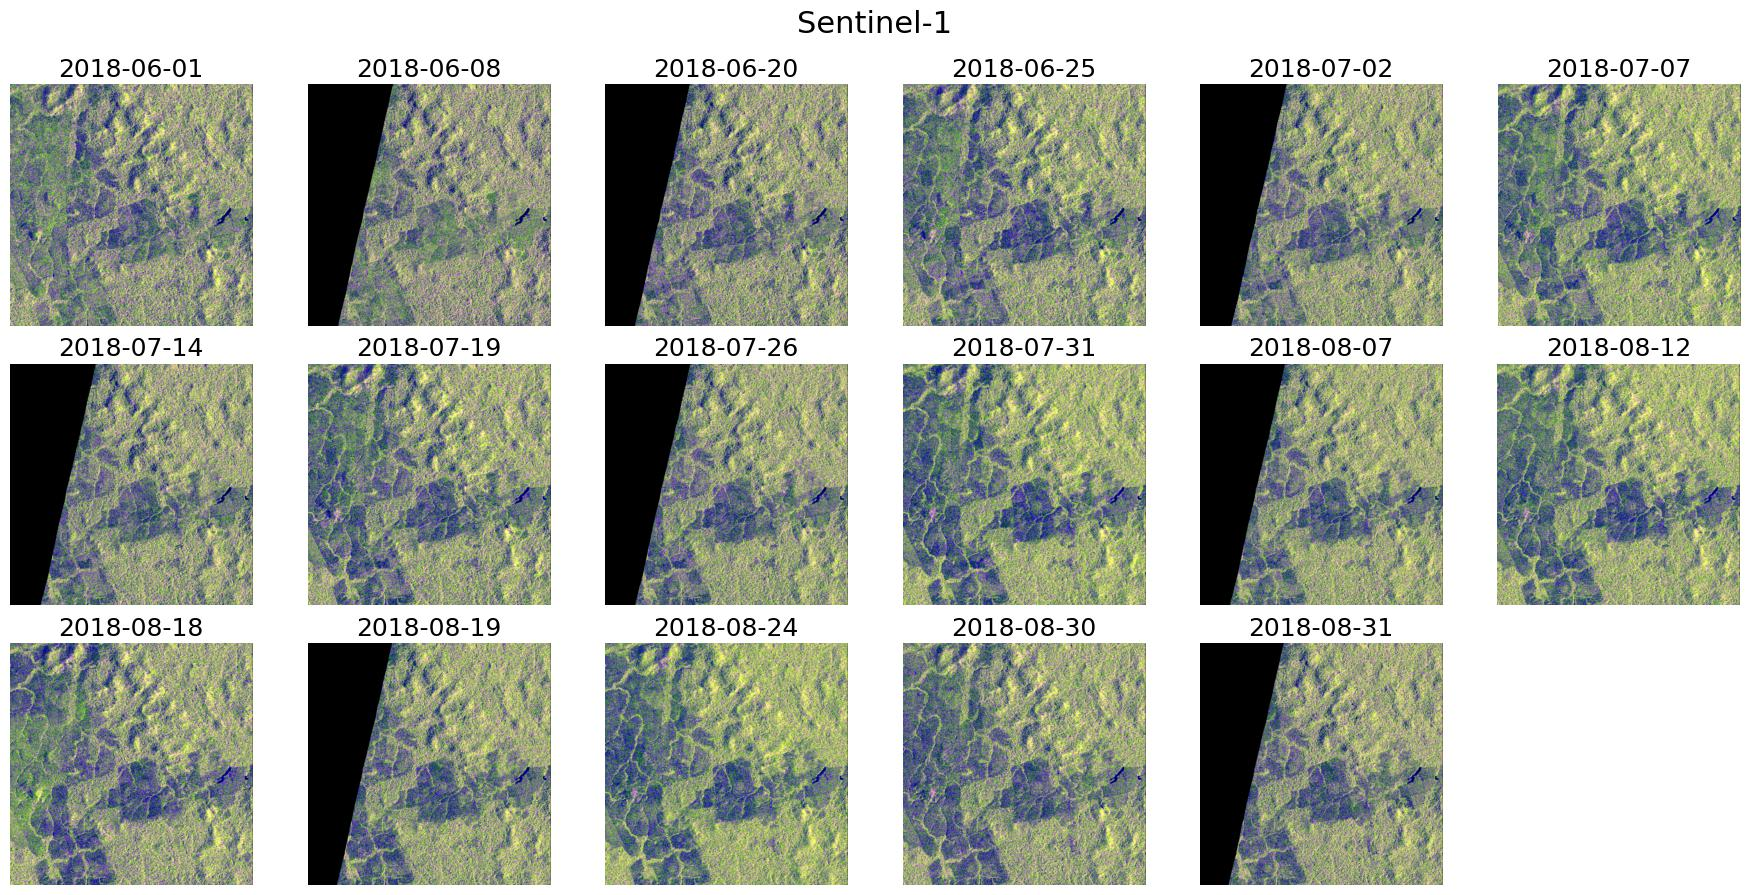

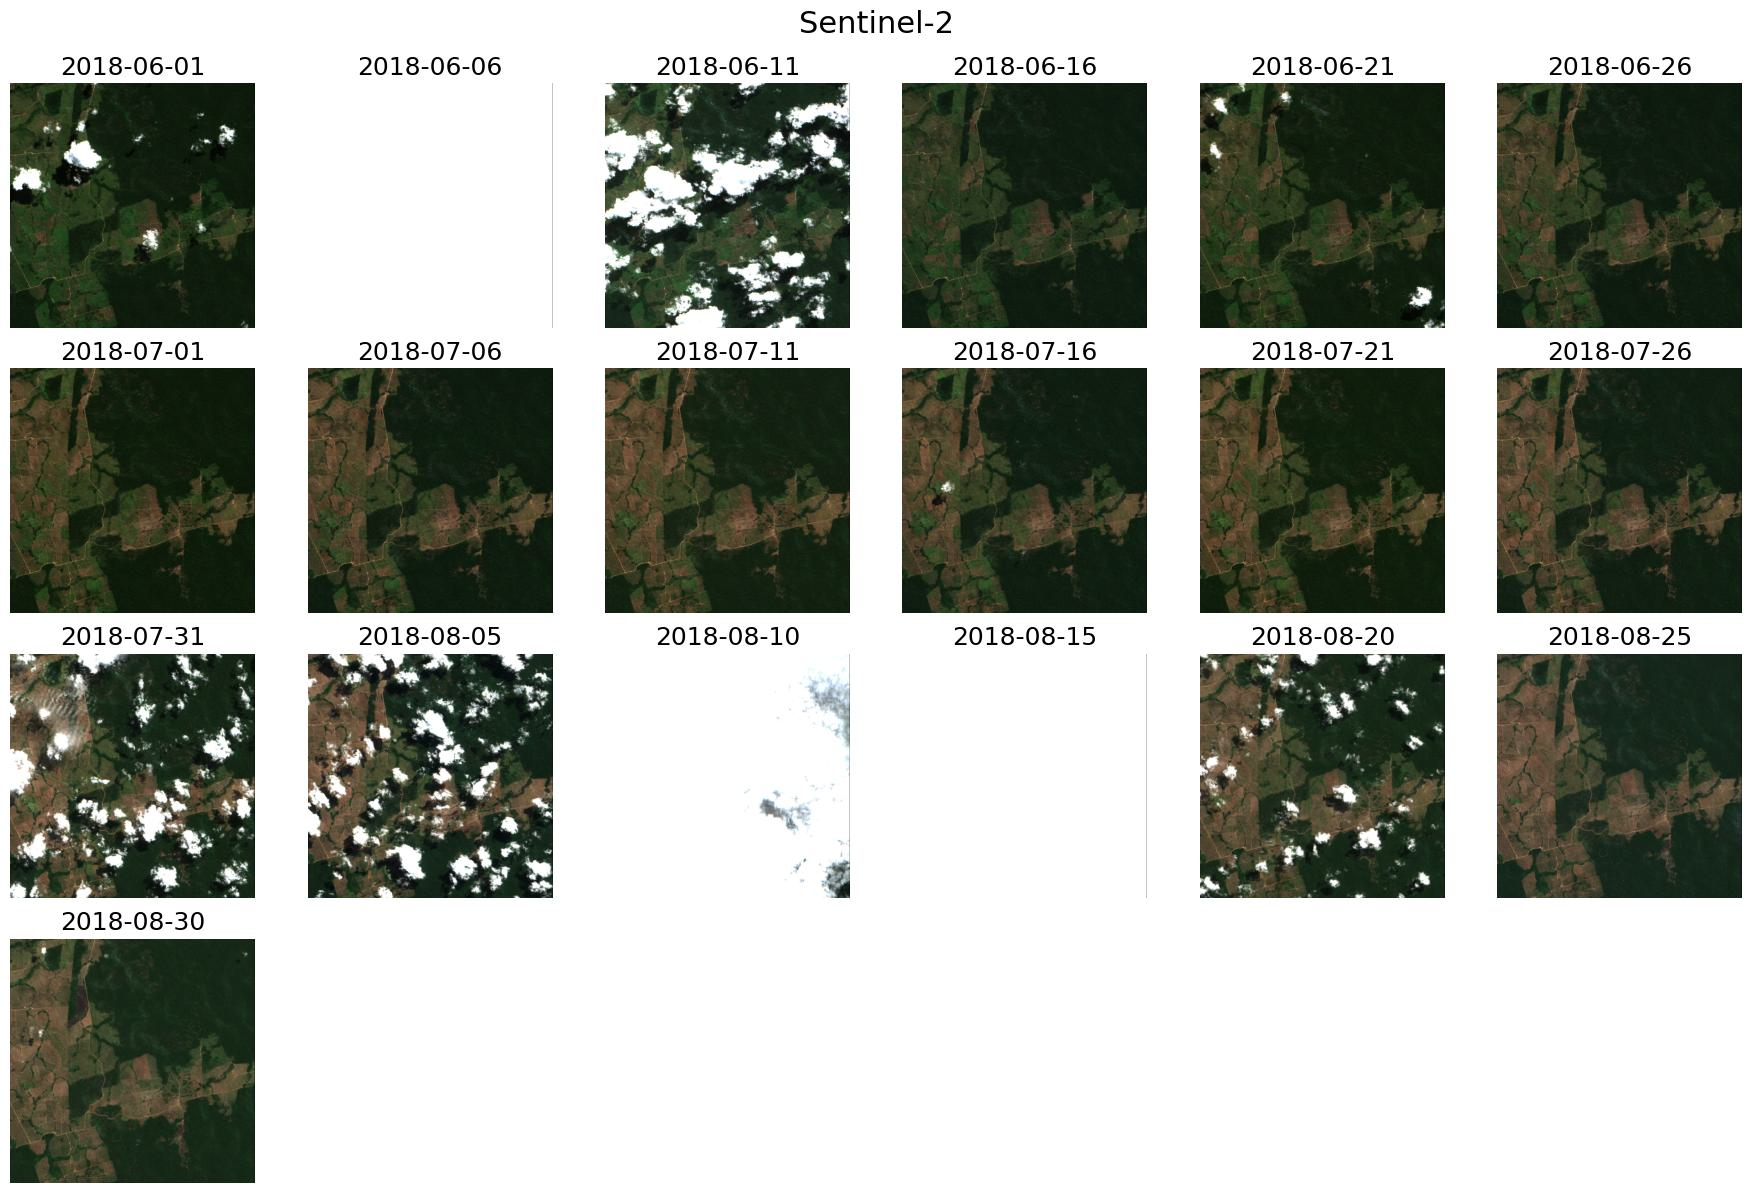

In [28]:
s1_rasters = sorted(s1_run.output["s1_raster"], key=lambda x: x.time_range[0])
s2_rasters = sorted(s1_run.output["s2_raster"], key=lambda x: x.time_range[0])

N = 6
S = 3
H = math.ceil(len(s1_rasters) / N)
plt.figure(figsize=(N*S, H*S))
for i, r in enumerate(s1_rasters):
    plt.subplot(H, N, i + 1)
    plt.imshow(s1_to_img(read_raster(r, geometry=proj_geom)))
    plt.title(r.time_range[0].strftime("%Y-%m-%d"), fontsize=18)
    plt.axis("off")
plt.suptitle("Sentinel-1", fontsize=22, y=.99)
plt.tight_layout()
lw_plot()

H = math.ceil(len(s2_rasters) / N)
plt.figure(figsize=(N*S, H*S))
for i, r in enumerate(s2_rasters):
    plt.subplot(H, N, i + 1)
    plt.imshow(s2_to_img(read_raster(r, geometry=proj_geom)))
    plt.title(r.time_range[0].strftime("%Y-%m-%d"), fontsize=18)
    plt.axis("off")
plt.suptitle("Sentinel-2", fontsize=22, y=.99)
plt.tight_layout()
lw_plot()

Here is a close up of two days for which there are both Sentinel-1 and Sentinel-2 images. We can see that for cloudy and cloudless days the Sentinel-1 image remains unaffected.

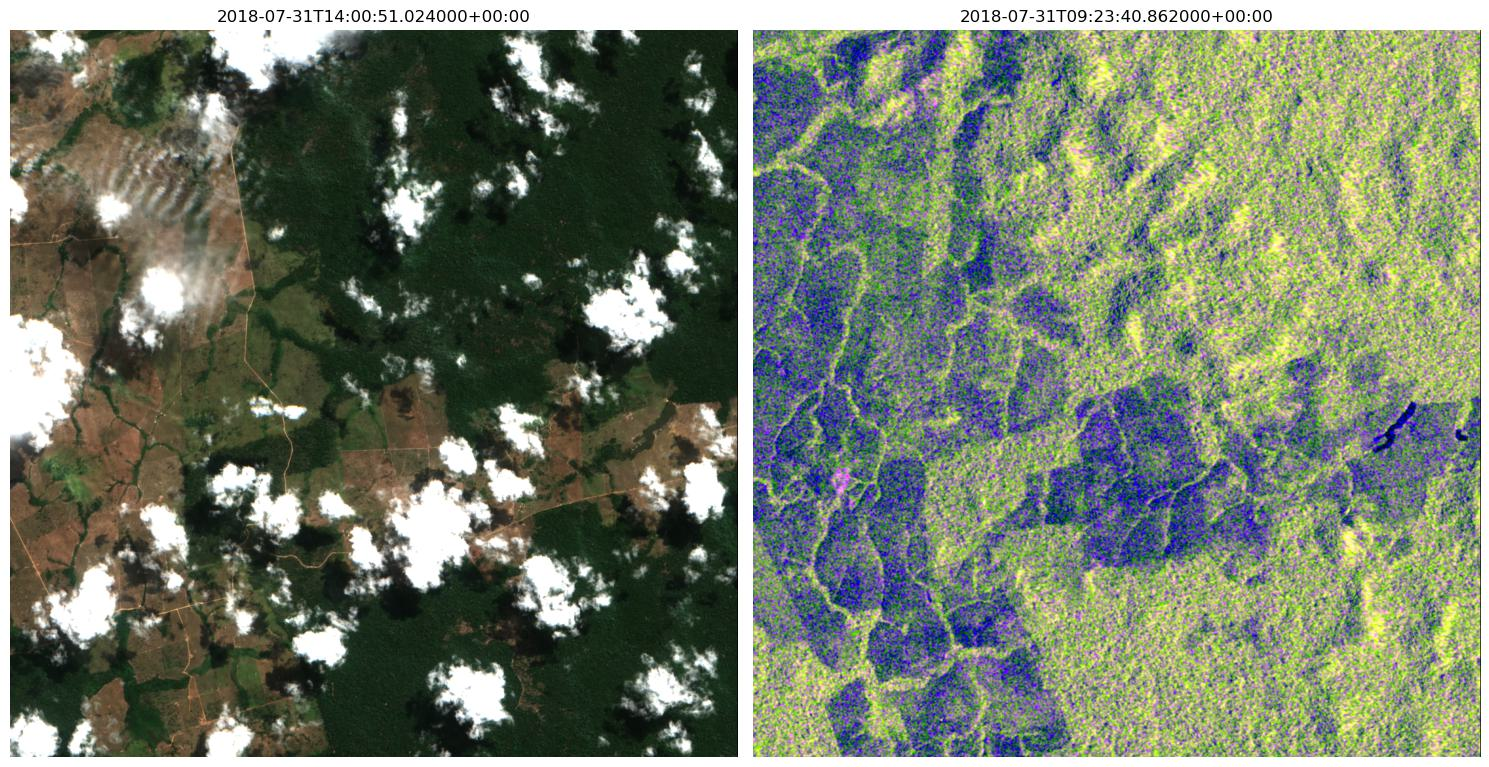

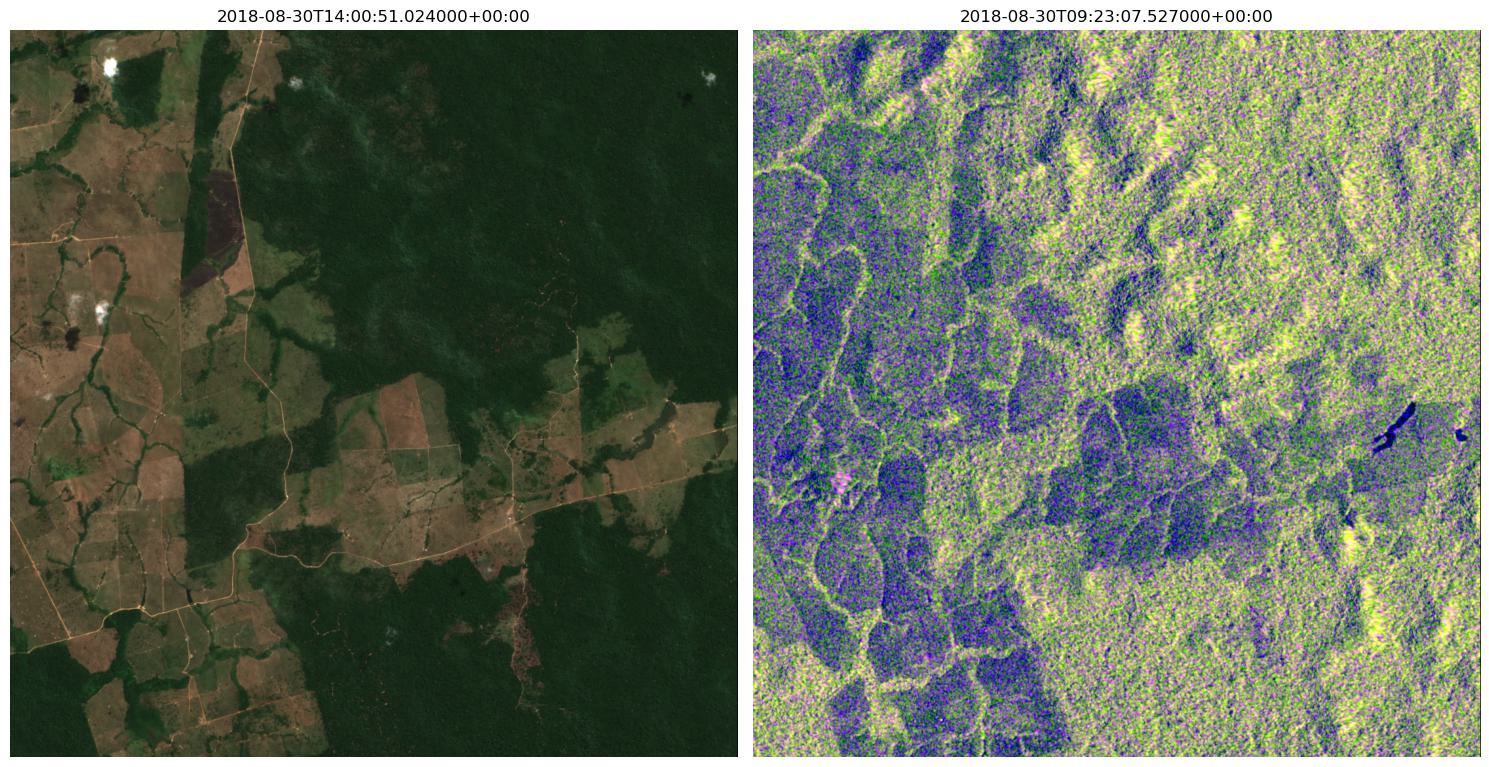

In [29]:
for idx1, idx2 in zip((7, 1), (6, 0)):
    s1 = s1_run.output["s1_raster"][idx1]
    s2 = s1_run.output["s2_raster"][idx2]
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(s2.time_range[0].isoformat())
    plt.imshow(s2_to_img(read_raster(s2, geometry=proj_geom)))
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title(s1.time_range[0].isoformat())
    plt.imshow(s1_to_img(read_raster(s1, geometry=proj_geom)))
    plt.tight_layout()
    lw_plot()

# SpaceEye
SpaceEye is a technique that fuses both Sentinel-1 and Sentinel-2 data in order to generate daily cloud-free Sentinel-2 imagery. It uses a neural network to map sequences of Sentinel-1 and Sentinel-2 images into a sequence of cloud-free Sentinel-2 images. More information about SpaceEye is available in [the paper](https://arxiv.org/abs/2106.08408). The model operates on a spatio-temporal window (48 days and 448x448 pixels at 10m resolution, by default). The platform will automatically split the input data, perform inference over each window, and merge the results into a series of rasters. This step not performed at the tile level, like the former ops, so the output will be just for our input geometry.

In [30]:
se_run = client.run("data_ingestion/spaceeye/spaceeye", "SpaceEye Amazon 2018", geometry=geom, time_range=time_range)
se_run.monitor()

Output()

## Daily imagery
While Sentinel-2 images are available at an approximate 5-day interval, the SpaceEye model performs temporal interpolation and generates images daily in the input interval.

Sentinel-2 rasters: 19
SpaceEye rasters: 93


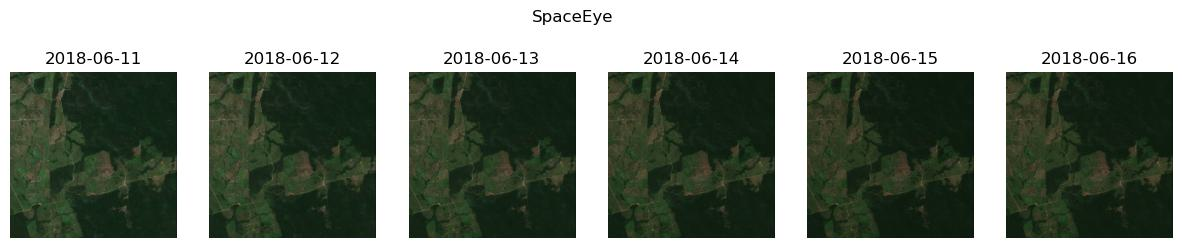

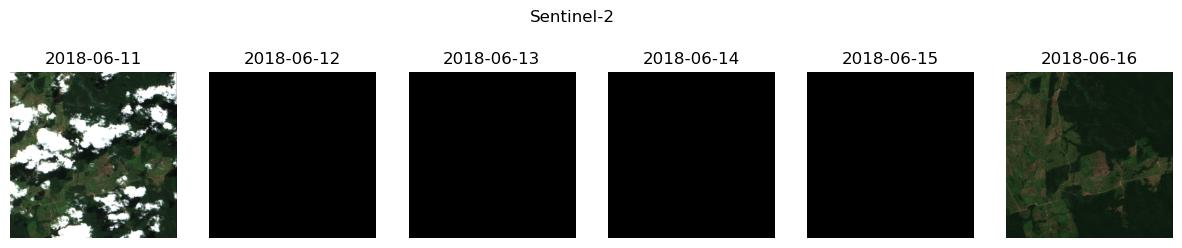

In [31]:
# Daily imagery
print(f"Sentinel-2 rasters: {len(runs[0].output['raster'])}")
print(f"SpaceEye rasters: {len(se_run.output['raster'])}")

for r, rgb_idx, name in zip(
    (se_run.output["raster"], runs[0].output["raster"]),
    ([2, 1, 0], [3, 2, 1]),
    ("SpaceEye", "Sentinel-2")
):
    plt.figure(figsize=(15, 3))
    for i in range(1, 7):
        plt.subplot(1, 6, i)
        ref_date = date(2018, 6, i+10)
        match_raster = [rr for rr in r if rr.time_range[0].date() == ref_date]
        if match_raster:
            match_ar = s2_to_img(read_raster(match_raster[0], geometry=proj_geom), rgb_idx=rgb_idx)
            plt.imshow(match_ar)
            
        else:
            plt.imshow(no_data)
        plt.axis("off")
        plt.title(ref_date.strftime("%Y-%m-%d"))
    plt.suptitle(f"{name}")
    lw_plot()
    no_data = np.zeros_like(match_ar)

## Cloud inpainting
Below is a comparison of some days for which Sentinel-2 images are available. SpaceEye reconstructs regions occluded by clouds and cloud shadows.

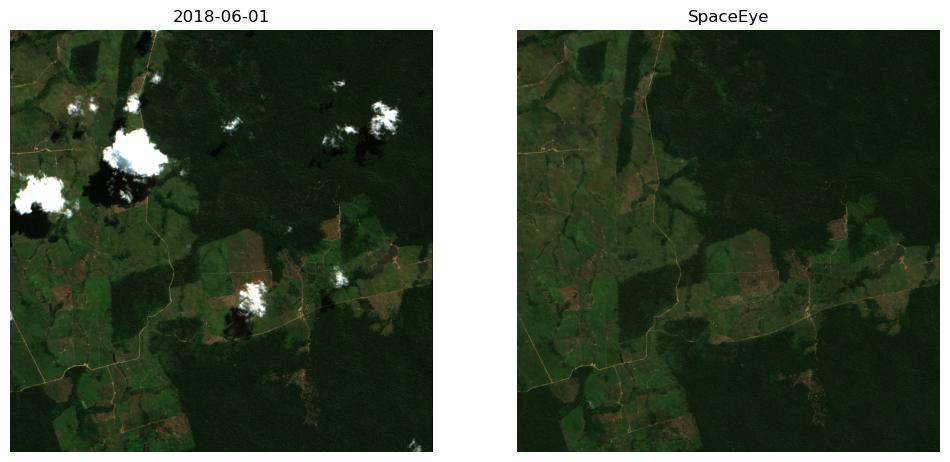

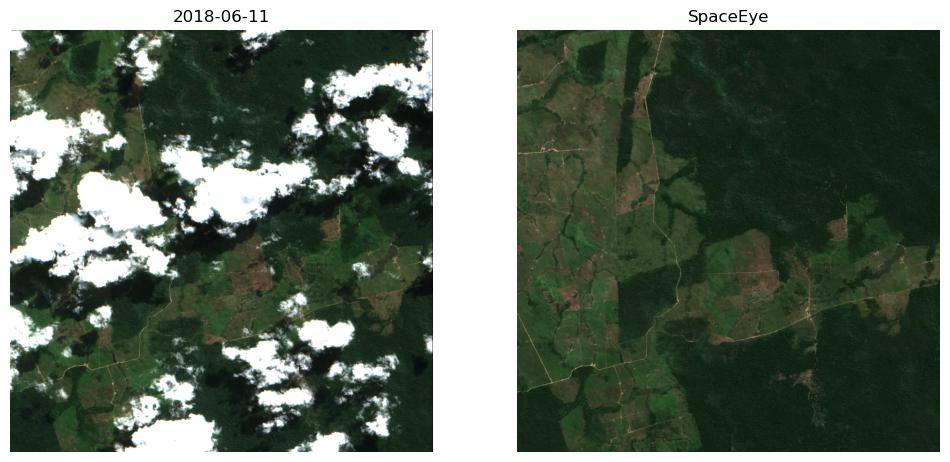

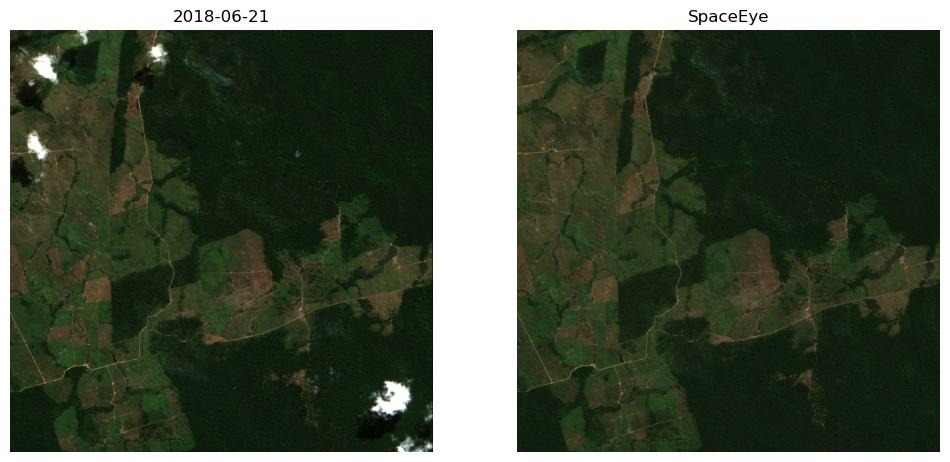

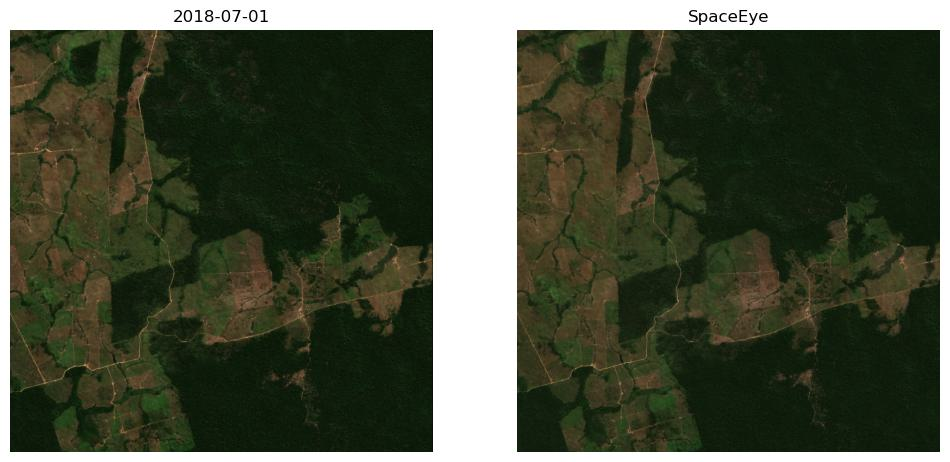

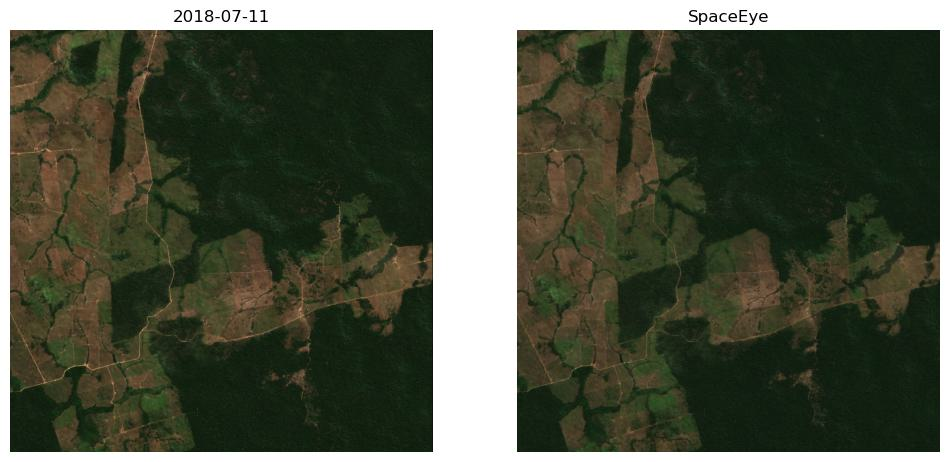

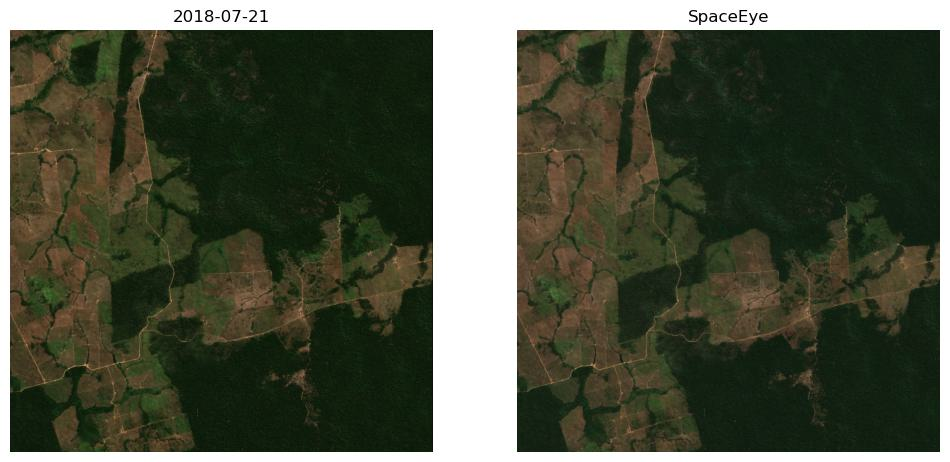

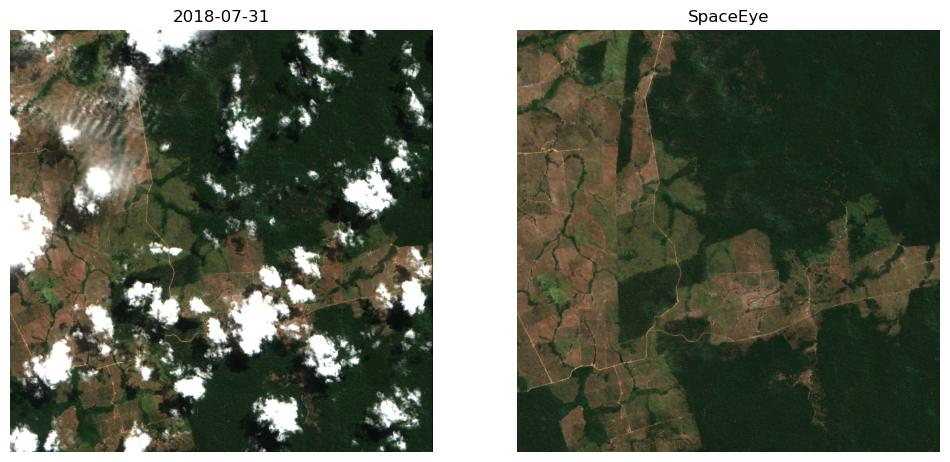

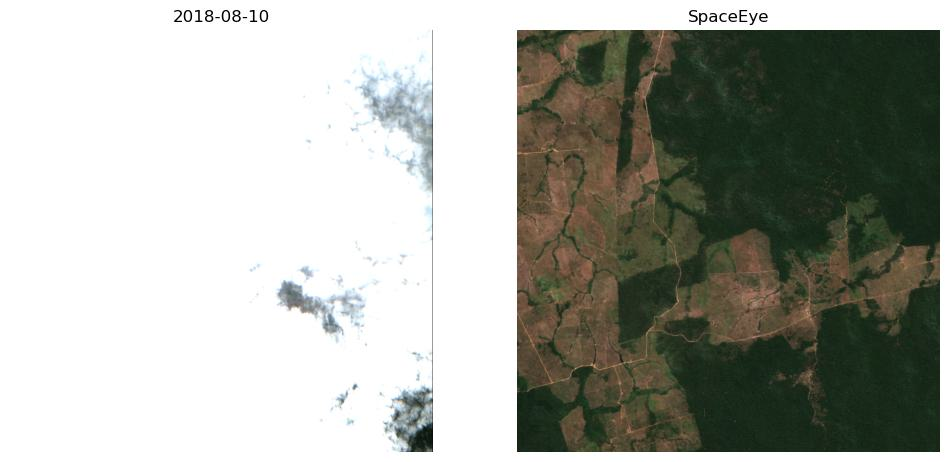

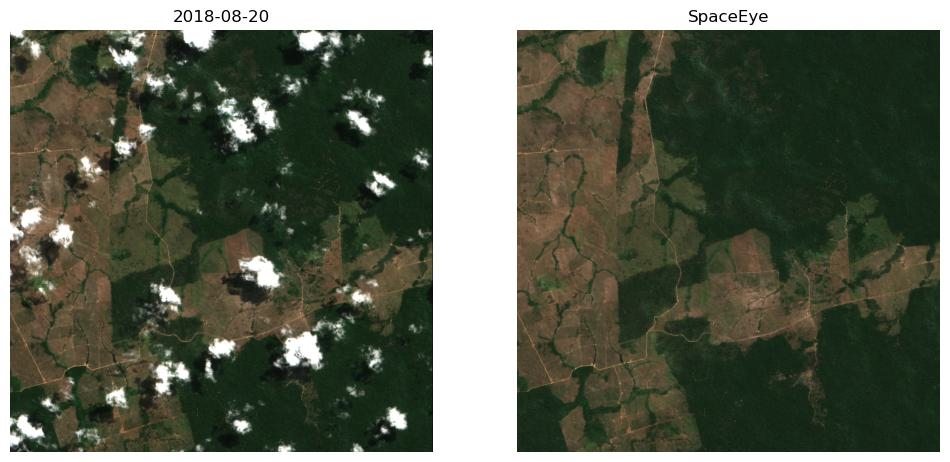

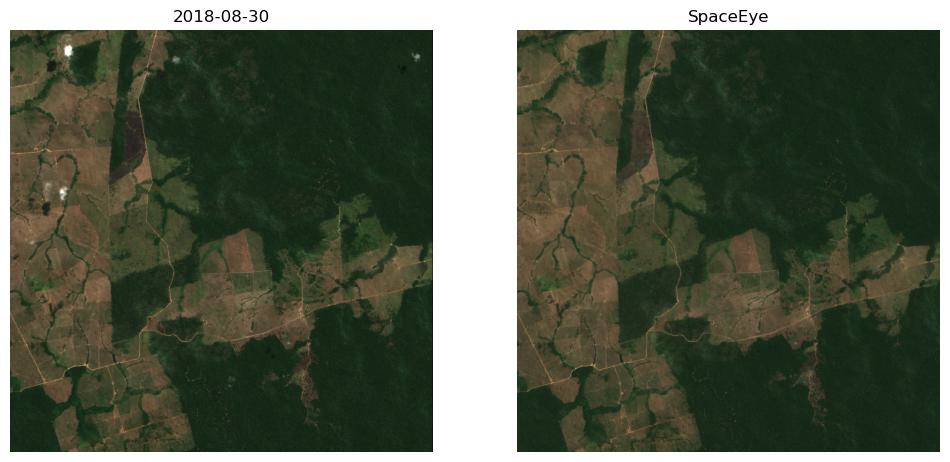

In [32]:
for s2 in sorted(runs[0].output["raster"][::2], key=lambda x: x.time_range[0]):
    plt.figure(figsize=(12, 6))
    se_raster = sorted(se_run.output["raster"], key=lambda x: abs(s2.time_range[0] - x.time_range[0]))[0]
    plt.subplot(1, 2, 1)
    plt.title(s2.time_range[0].strftime("%Y-%m-%d"))
    plt.imshow(s2_to_img(read_raster(s2, geometry=proj_geom)))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(s2_to_img(read_raster(se_raster), rgb_idx=[2, 1, 0]))
    plt.title("SpaceEye")
    plt.axis("off")
    lw_plot()

# Inpainting via damped interpolation
There is a second SpaceEye method for generating daily cloud-free images available at FarmVibes.AI. It is based on temporal damped interpolation of cloud-free pixels. This method does not fuse Sentinel-1 data, relying solely on cloud-free Sentinel-2 data to inpaint pixels. It can be accessed via the `data_ingestion/spaceeye/spaceeye_interpolation` workflow.

In [33]:
se_interp_run = client.run(
    "data_ingestion/spaceeye/spaceeye_interpolation",
    "Amazon SpaceEye Interpolation 2020",
    geometry=geom,
    time_range=time_ranges[2])
se_interp_run.monitor()

Output()

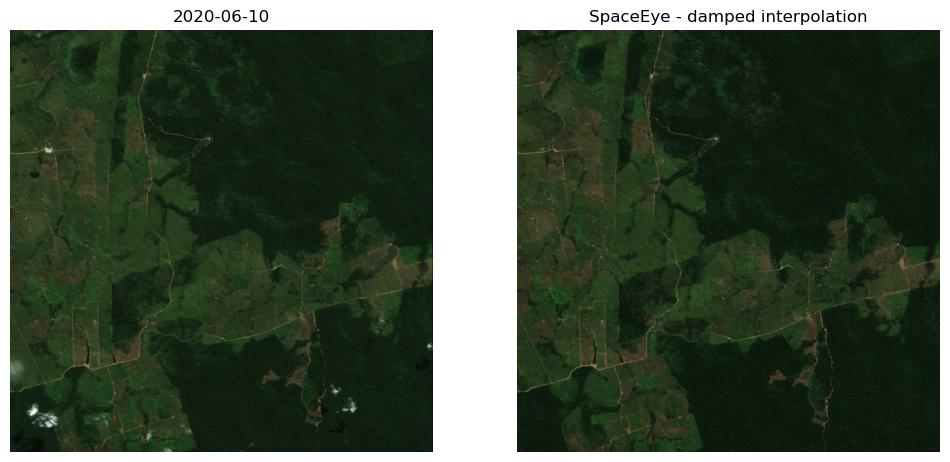

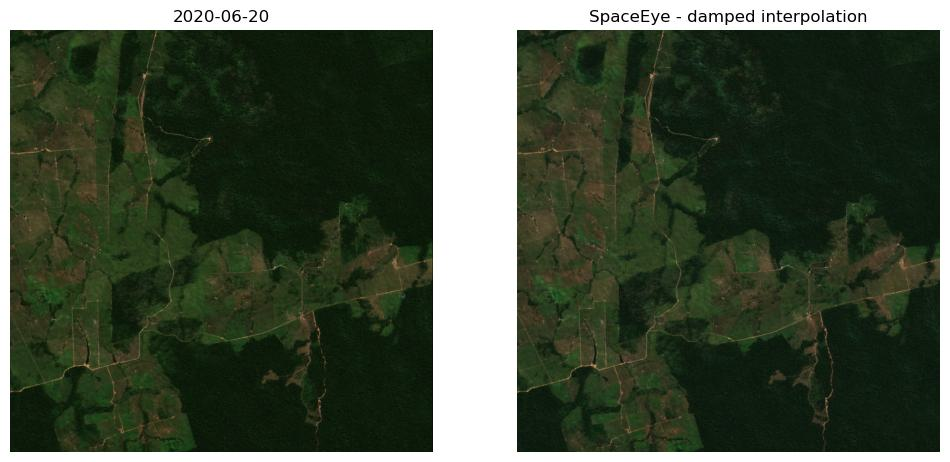

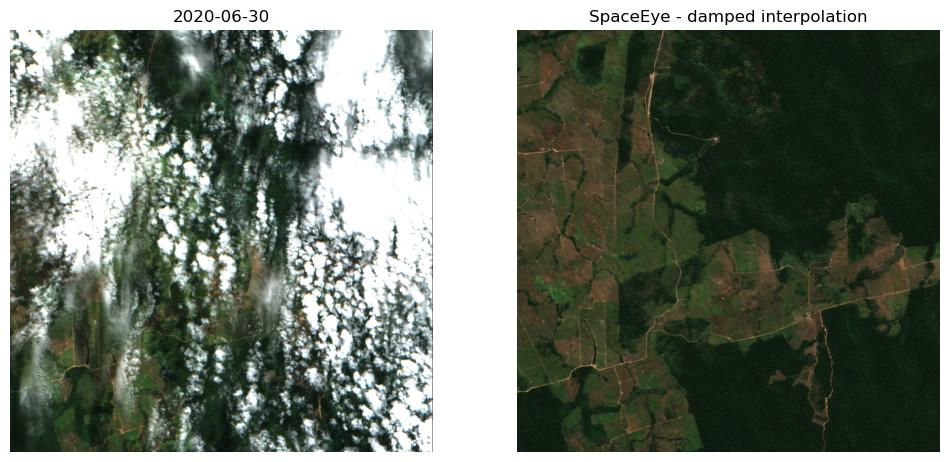

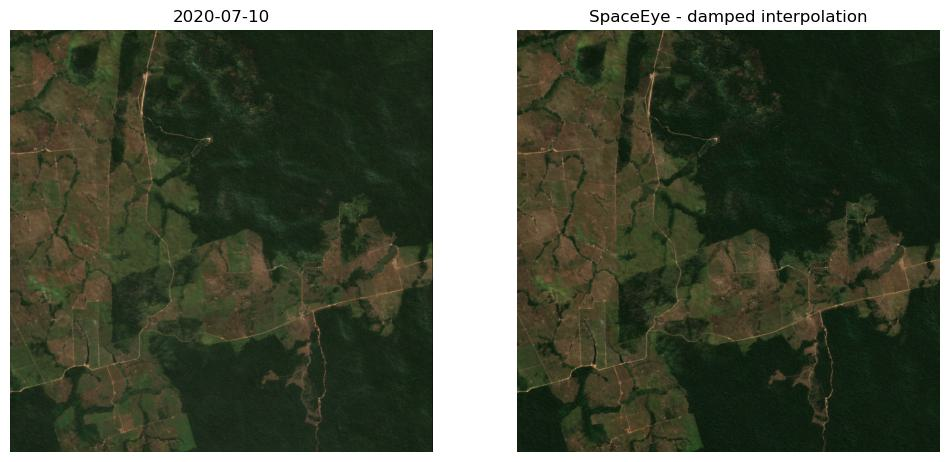

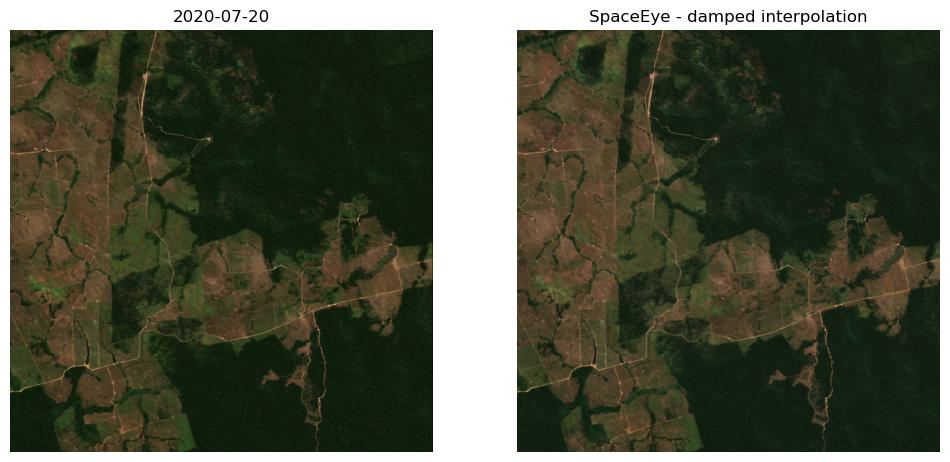

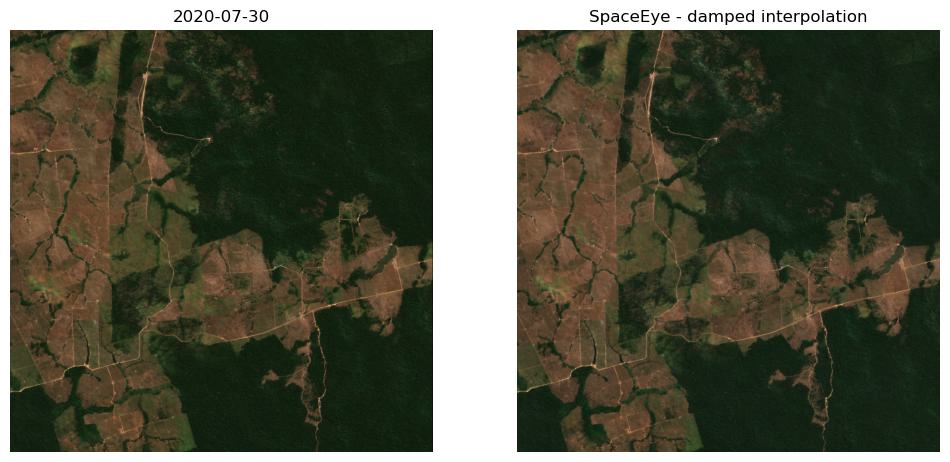

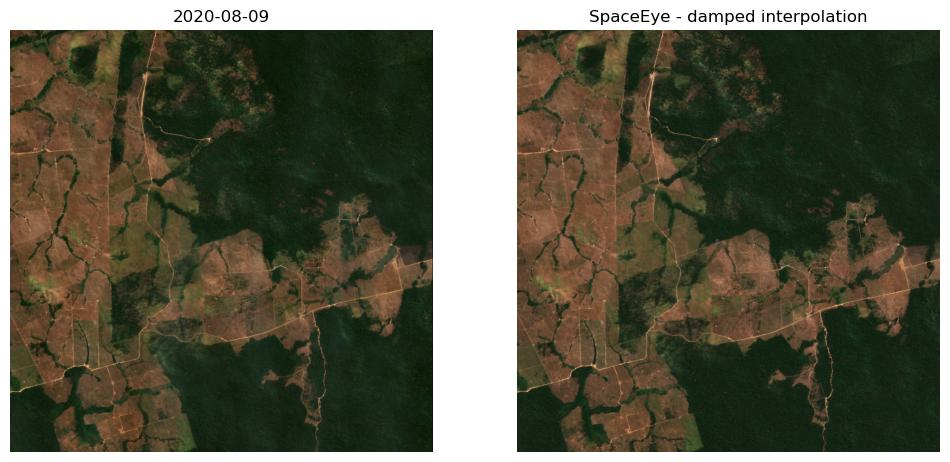

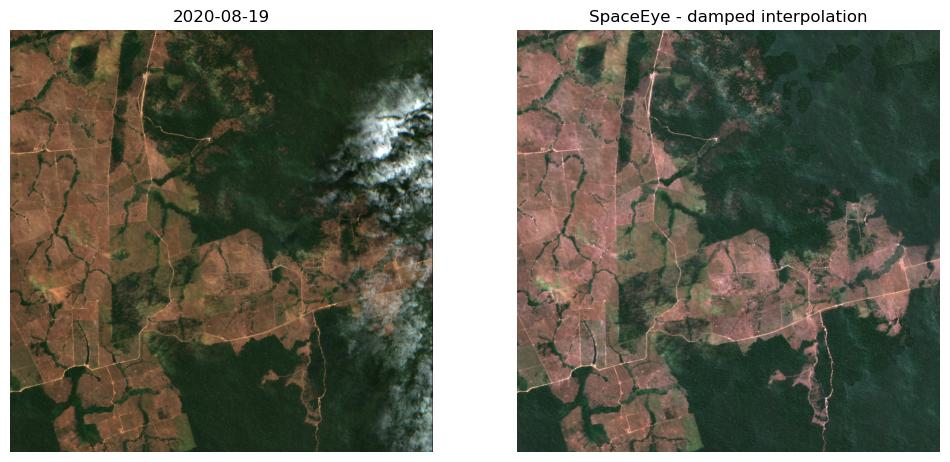

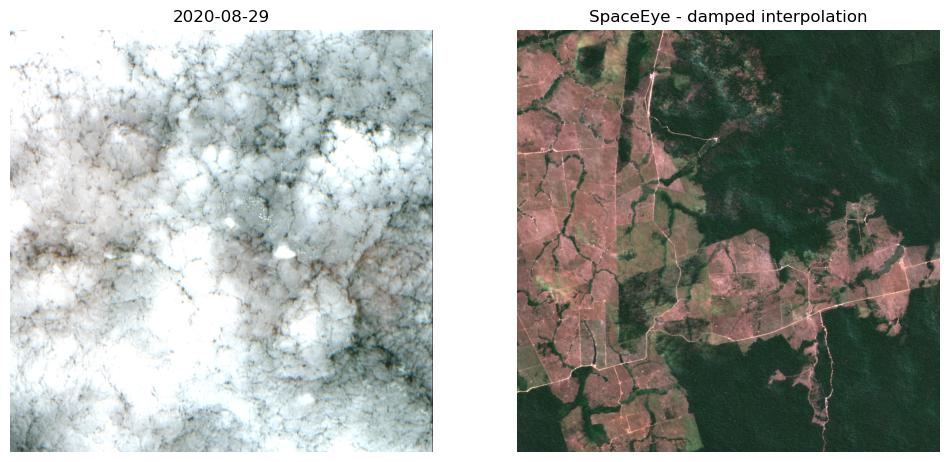

In [34]:
for s2 in sorted(runs[2].output["raster"][::2], key=lambda x: x.time_range[0]):
    plt.figure(figsize=(12, 6))
    se_raster = sorted(se_interp_run.output["raster"], key=lambda x: abs(s2.time_range[0] - x.time_range[0]))[0]
    plt.subplot(1, 2, 1)
    plt.title(s2.time_range[0].strftime("%Y-%m-%d"))
    plt.imshow(s2_to_img(read_raster(s2, geometry=proj_geom)))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(s2_to_img(read_raster(se_raster), rgb_idx=[2, 1, 0]))
    plt.title("SpaceEye - damped interpolation")
    plt.axis("off")
    lw_plot()